In [583]:
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression ,LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.nei import 


import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [601]:
df=pd.read_csv('Data.txt',encoding='cp1251',delimiter=';')
df_original=df.copy()
df_sum=DataFrameSummary(df)

In [602]:
dict_to_replace={'Дефолт':1 ,'Нет дефолта': 0}
df['Флаг дефолта по кредиту']=df['Флаг дефолта по кредиту'].map(dict_to_replace)
df['Тип товара']=df['Тип товара'].replace({'Детские товары (игрушки, детская одежда, детская мебель)':'Дет. товары'})
df_original['Тип товара']=df_original['Тип товара'].replace({'Детские товары (игрушки, детская одежда, детская мебель)':'Дет. товары'})
categorical_columns=df.dtypes[df.dtypes=='object'].index
d = defaultdict(LabelEncoder)
df[categorical_columns] = df[categorical_columns].apply(lambda x: d[x.name].fit_transform(x))

map_dict=[{i:dict(list(zip(d[i].classes_,range(0,len(d[i].classes_))))) for i in categorical_columns}]
df['Является ли клиентом банка']=df['Является ли клиентом банка'].replace({1:0,0:1})
map_dict[0]['Является ли клиентом банка']['Клиент банка']=1
map_dict[0]['Является ли клиентом банка']['Не клиент банка']=0

df['Образование клиента']=df['Образование клиента'].replace({2:0,4:1,5:2,1:3,0:4,3:5})
map_dict[0]['Образование клиента']['Неоконченное среднее']=0
map_dict[0]['Образование клиента']['Среднее']=1
map_dict[0]['Образование клиента']['Среднее специальное']=2
map_dict[0]['Образование клиента']['Неоконченное высшее']=3
map_dict[0]['Образование клиента']['Высшее']=4
map_dict[0]['Образование клиента']['Несколько высших или более высокая ступень образования']=5
map_dict

df['Сбережения после отданной месячной нормы']=df['Доход клиента']-df['Сумма кредита']/df['Срок кредита']
df['Сбережения/Зарплата']=df['Сбережения после отданной месячной нормы']/df['Доход клиента']
df['Месяц отдачи кредита']=(df['Месяц выдачи кредита']+df['Срок кредита'])%12
df['Месяц отдачи кредита']=df['Месяц отдачи кредита'].replace({0:12})
df['Возраст клиента по категории']=pd.cut(df['Возраст клиента'],bins=[0,11,17,25,40,54,100],right=True 
#                                           ,labels=['Детсад','Школьники','Юно-ий возраст','Взрослые','Зрелые','Пенсионеры'])
                                            ,labels=[0,1,2,3,4,5])

In [586]:
map_dict

[{'Наличие детей у клиента': {'Детей нет': 0, 'Дети есть': 1},
  'Образование клиента': {'Высшее': 4,
   'Неоконченное высшее': 3,
   'Неоконченное среднее': 0,
   'Несколько высших или более высокая ступень образования': 5,
   'Среднее': 1,
   'Среднее специальное': 2},
  'Оператор связи': {'Билайн': 0,
   'Другой': 1,
   'МТС': 2,
   'Мегафон': 3,
   'Теле2': 4},
  'Пол клиента': {'Женский': 0, 'Мужской': 1},
  'Регион выдачи кредита': {'Другие регионы': 0,
   'Москва или МО': 1,
   'Санкт-Петербург или ЛО': 2},
  'Семейное положение': {'Другое': 0,
   'Женат/замужем': 1,
   'Никогда не был(а) женат/замужем': 2},
  'Тип товара': {'Автомобильные товары': 0,
   'Аудио, Видео, Фото': 1,
   'Бытовая техника': 2,
   'Дет. товары': 3,
   'Компьютеры, комплектующие': 4,
   'Косметика и косметические услуги': 5,
   'Мебель': 6,
   'Медицинские услуги': 7,
   'Мобильные телефоны': 8,
   'Мототехника (лодки, мото)': 9,
   'Музыка': 10,
   'Обучение': 11,
   'Одежда, изделия из меха и кожи': 12

In [210]:
df.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту,Сбережения после отданной месячной нормы,Сбережния/Зарплату,Месяц отдачи кредита,Возраст клиента по категории
0,1,7000,12,39,1,2,8,0,0,21000,0,2,0,0,20416.666667,0.972222,1,3
1,1,19000,6,20,1,2,2,1,0,17000,0,4,1,0,13833.333333,0.813725,7,2
2,1,29000,12,23,0,2,2,0,0,31000,0,0,0,0,28583.333333,0.922043,1,2
3,1,10000,12,30,1,2,8,1,0,31000,2,4,1,0,30166.666667,0.973118,1,3
4,1,14500,12,25,0,4,8,0,0,26000,1,2,1,0,24791.666667,0.953526,1,3


In [7]:
df_sum.columns_stats

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
counts,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723
uniques,12,205,22,66,2,6,22,2,3,76,3,5,2,2
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,numeric,numeric,numeric,numeric,bool,categorical,categorical,bool,categorical,numeric,categorical,categorical,bool,bool


In [131]:
df.describe()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
count,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.00000,1723.000000,1723.000000,1723.000000
mean,6.708067,29264.654672,11.546721,35.911782,0.540337,2.969820,6.785839,0.428323,0.219385,32652.350551,0.34823,2.208358,0.604759,0.113755
std,3.538420,27926.778301,6.548354,13.120203,0.498515,2.306939,4.875689,0.494979,0.501492,20913.193158,0.56364,1.227397,0.489044,0.317606
min,1.000000,5000.000000,3.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.00000,0.000000,0.000000,0.000000
25%,3.000000,13000.000000,6.000000,26.000000,0.000000,0.000000,2.000000,0.000000,0.000000,21000.000000,0.00000,2.000000,0.000000,0.000000
50%,7.000000,21500.000000,12.000000,32.000000,1.000000,4.000000,6.000000,0.000000,0.000000,27000.000000,0.00000,2.000000,1.000000,0.000000
75%,10.000000,34000.000000,12.000000,44.000000,1.000000,5.000000,8.000000,1.000000,0.000000,38000.000000,1.00000,3.000000,1.000000,0.000000
max,12.000000,301000.000000,36.000000,90.000000,1.000000,5.000000,21.000000,1.000000,2.000000,401000.000000,2.00000,4.000000,1.000000,1.000000


In [8]:
df_sum.columns_types

numeric        5
categorical    5
bool           4
Name: types, dtype: int64

In [219]:
(498+471)/1723

0.5623911781775972

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text xticklabel objects>)

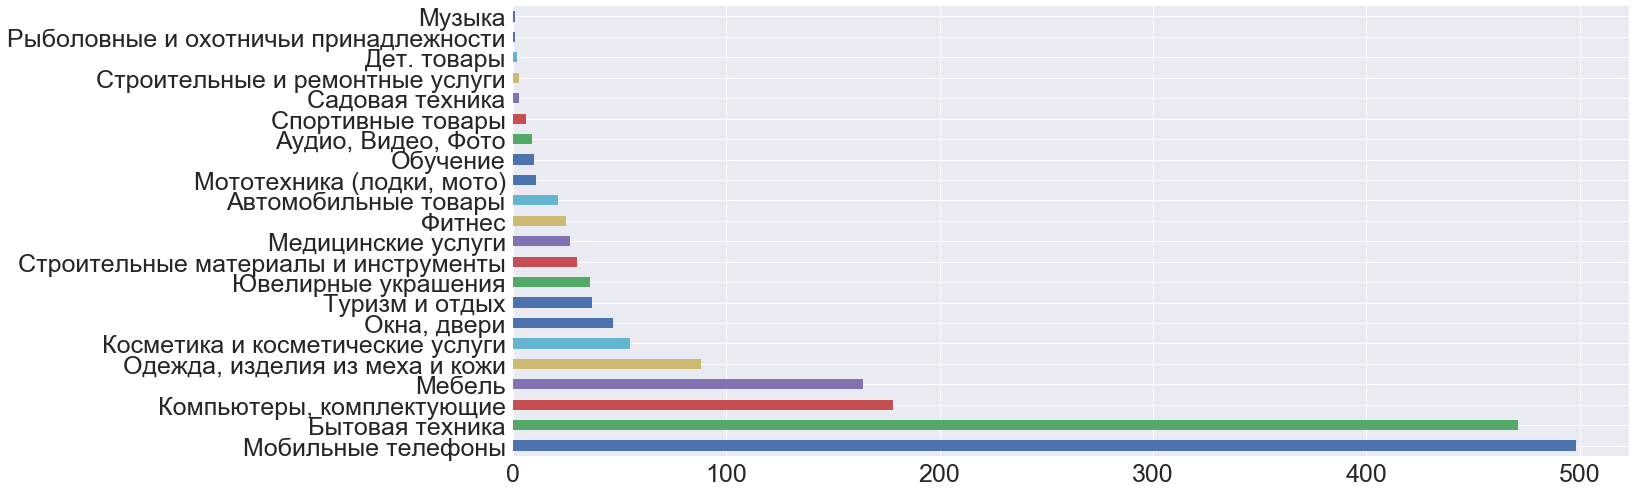

In [247]:
vals=df['Тип товара'].value_counts()
vals.index=d['Тип товара'].inverse_transform(vals.index.values)
ax=vals.plot.barh(rot=0)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

"0" count         1527
"0" perc        88.62%
"1" count          196
"1" perc        11.38%
counts            1723
uniques              2
missing              0
missing_perc        0%
types             bool
Name: Флаг дефолта по кредиту, dtype: object


C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


TypeError: xlabel() missing 1 required positional argument: 's'

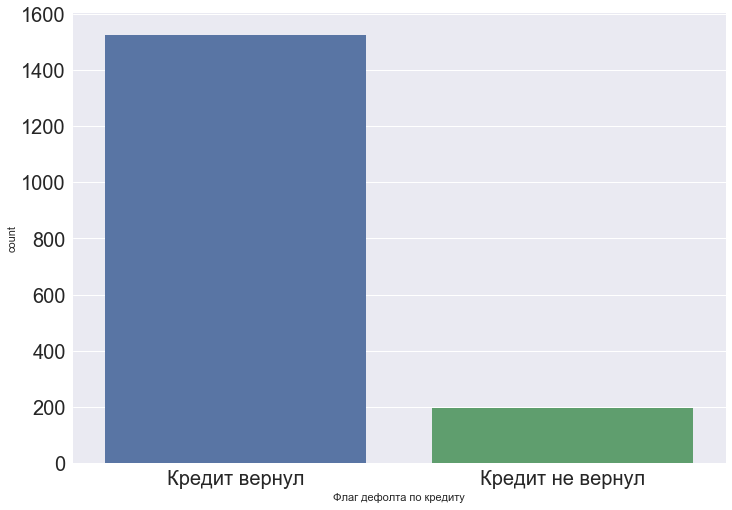

In [225]:
print (df_sum['Флаг дефолта по кредиту'])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(df['Флаг дефолта по кредиту'].replace({0:'Кредит вернул',1:'Кредит не вернул'}))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel(fontsize=25)
plt.ylabel(fontsize=25)

In [258]:
rel_freq_by_prod=df.groupby(['Тип товара','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack(level=-1).fillna(0)
rel_freq_by_prod.index=d['Тип товара'].inverse_transform(rel_freq_by_prod.index)
count_groups=df.groupby('Тип товара')['Флаг дефолта по кредиту'].count()
count_groups.index=d['Тип товара'].inverse_transform(count_groups.index)
rel_freq_by_prod=rel_freq_by_prod.reindex(vals.index)
count_groups=count_groups.reindex(vals.index)

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [281]:
count_groups

Мобильные телефоны                       498
Бытовая техника                          471
Компьютеры, комплектующие                178
Мебель                                   164
Одежда, изделия из меха и кожи            88
Косметика и косметические услуги          55
Окна, двери                               47
Туризм и отдых                            37
Ювелирные украшения                       36
Строительные материалы и инструменты      30
Медицинские услуги                        27
Фитнес                                    25
Автомобильные товары                      21
Мототехника (лодки, мото)                 11
Обучение                                  10
Аудио, Видео, Фото                         9
Спортивные товары                          6
Садовая техника                            3
Строительные и ремонтные услуги            3
Дет. товары                                2
Рыболовные и охотничьи принадлежности      1
Музыка                                     1
Name: Флаг

In [292]:
print(np.mean(rel_freq_by_prod.values[:,1]))
print(np.median(rel_freq_by_prod.values[:,1]))

7.226036823500025
4.519918283963229


Флаг дефолта по кредиту                         0          1
Мобильные телефоны                      77.309237  22.690763
Бытовая техника                         92.356688   7.643312
Компьютеры, комплектующие               95.505618   4.494382
Мебель                                  95.121951   4.878049
Одежда, изделия из меха и кожи          95.454545   4.545455
Косметика и косметические услуги        90.909091   9.090909
Окна, двери                             95.744681   4.255319
Туризм и отдых                          94.594595   5.405405
Ювелирные украшения                     77.777778  22.222222
Строительные материалы и инструменты    86.666667  13.333333
Медицинские услуги                      96.296296   3.703704
Фитнес                                 100.000000   0.000000
Автомобильные товары                    85.714286  14.285714
Мототехника (лодки, мото)               90.909091   9.090909
Обучение                               100.000000   0.000000
Аудио, Видео, Фото      

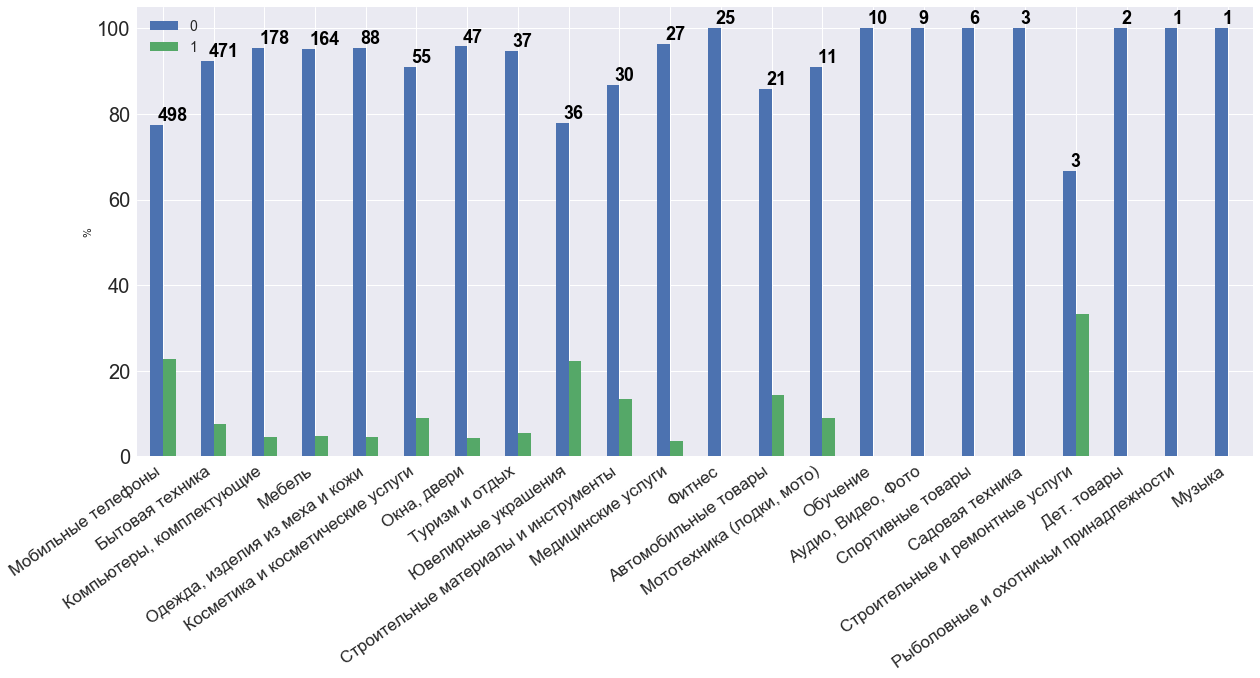

In [280]:
print(rel_freq_by_prod)
sns.set(rc={'figure.figsize':(20,8.27)})
rel_freq_by_prod.plot.bar(rot=90)
plt.yticks(fontsize=20)
plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')
plt.plot(x=rel_freq_by_prod.index, y=count_groups.values,color = 'orange',linewidth=4.0)
for i in range(0,len(rel_freq_by_prod.index)):
    plt.text(-0.1+i, max(rel_freq_by_prod.iloc[i])+1, count_groups.values[i], horizontalalignment='left', fontsize='18', color='black', weight='semibold')

In [321]:
df['Доход клиента'].median()

27000.0

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text xticklabel objects>)

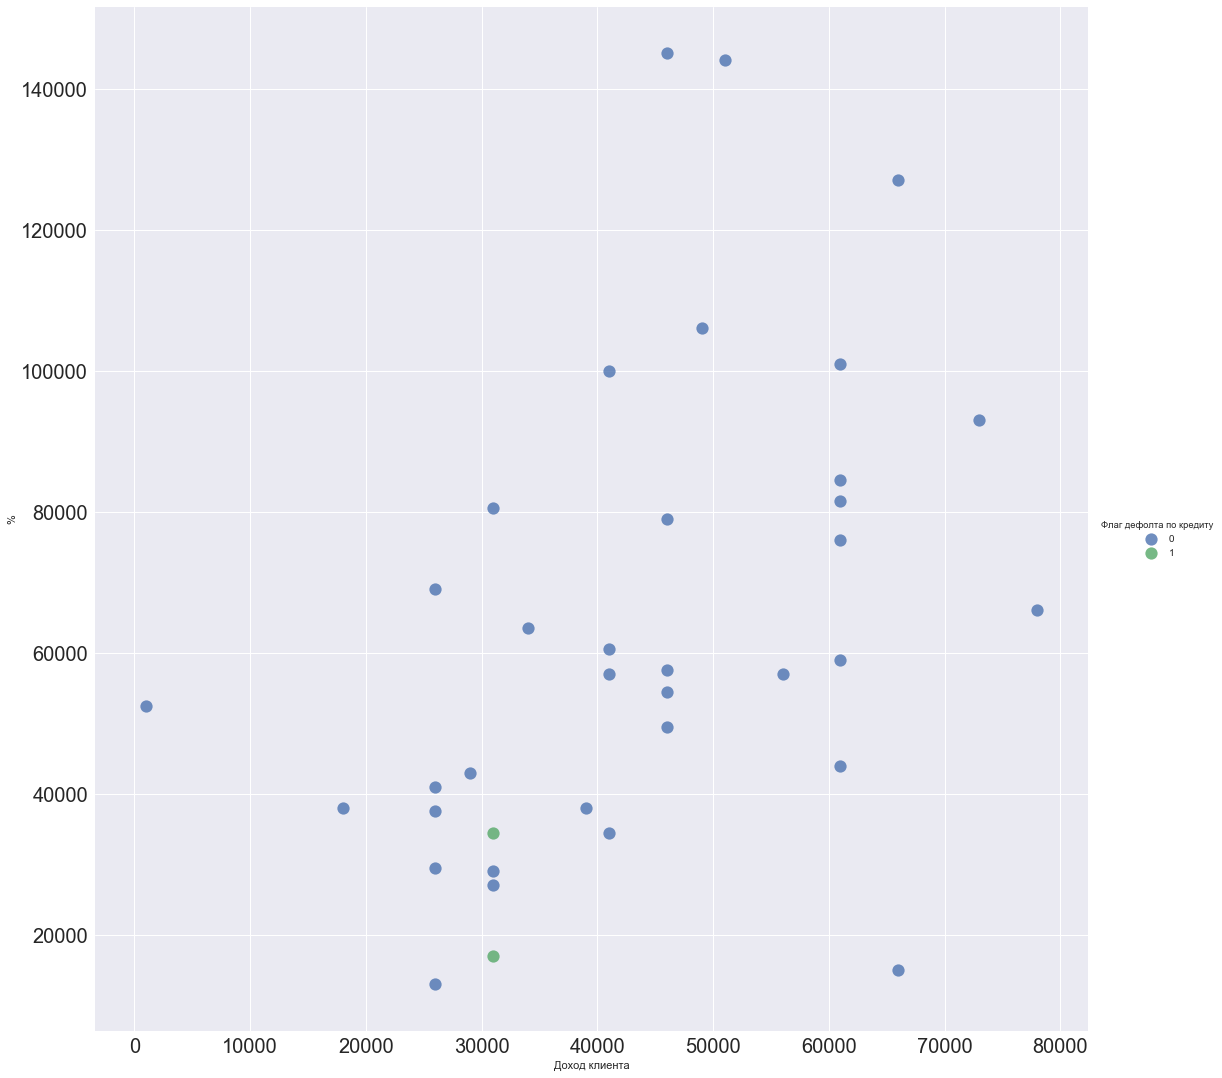

In [324]:
# sns.set(rc={'figure.figsize':(10.7,3.27)})
sns.lmplot(x='Доход клиента', y='Сумма кредита', data=df[df['Тип товара']==19],fit_reg=False, hue='Флаг дефолта по кредиту',size=15,x_jitter=True,scatter_kws={"s": 150})
plt.yticks(fontsize=20)
plt.ylabel('%')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

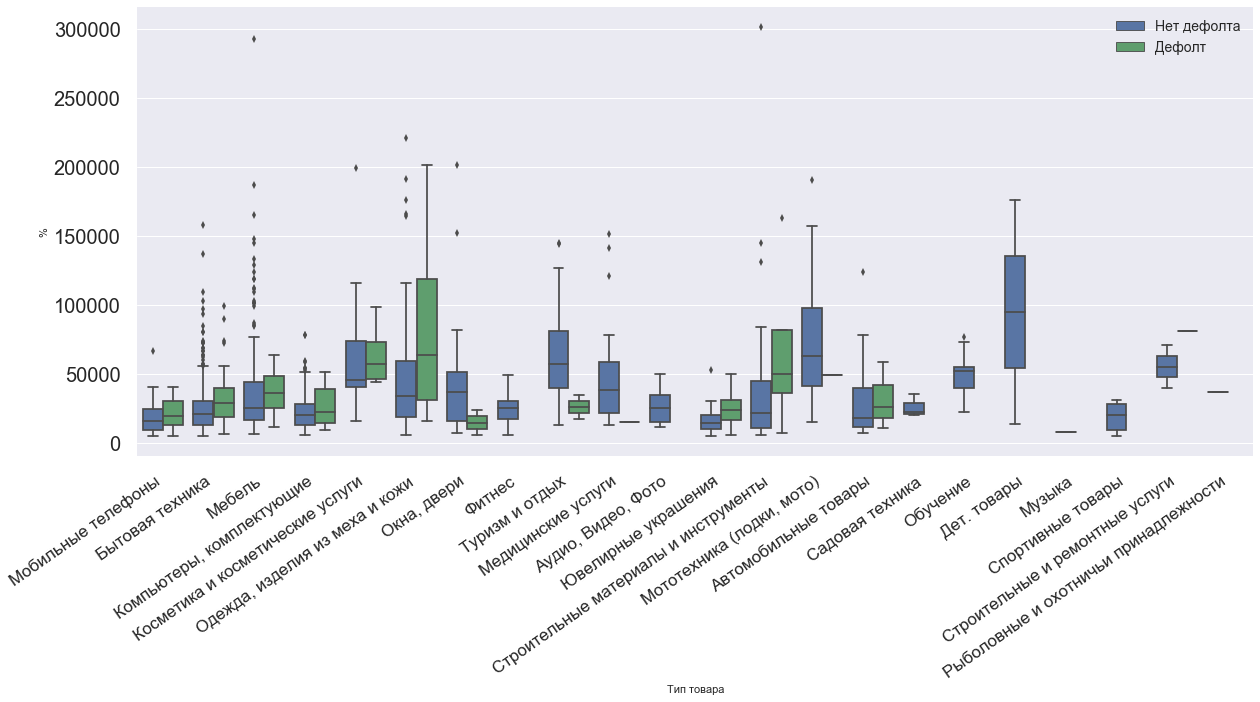

In [326]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.boxplot(x='Тип товара',y='Сумма кредита', hue='Флаг дефолта по кредиту', data=df_original)
sns.despine(offset=10, trim=True)
plt.yticks(fontsize=20)
plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

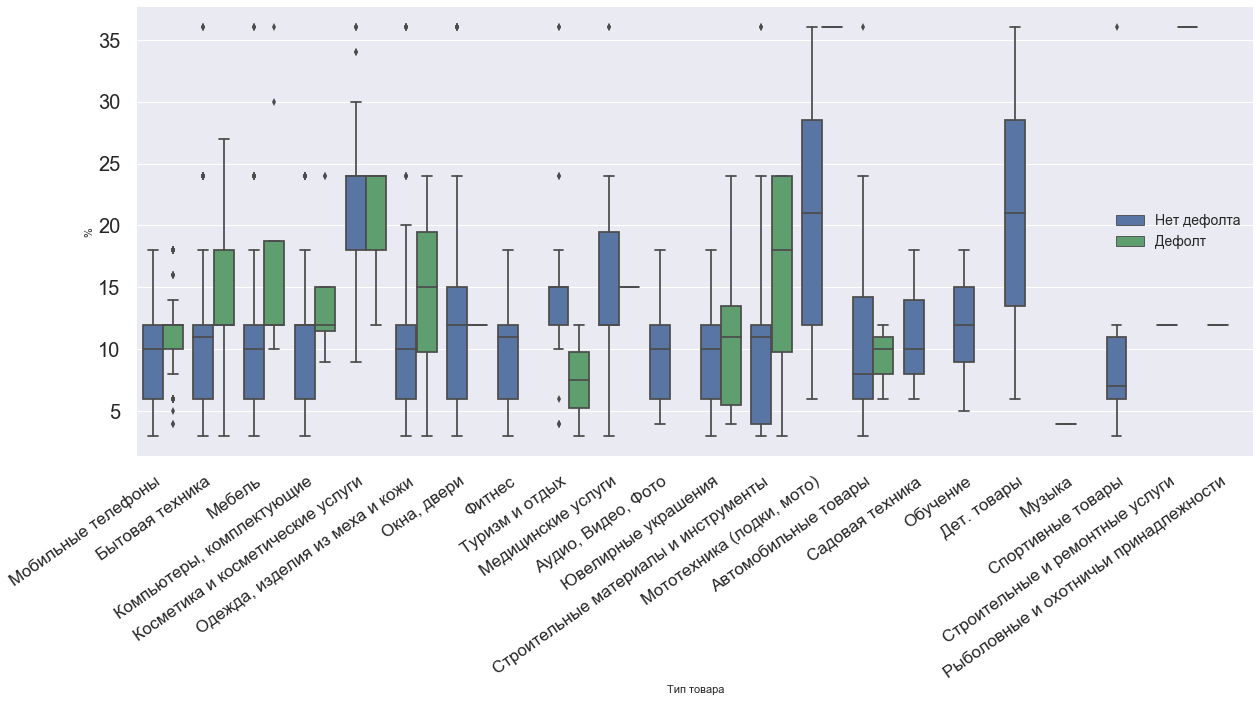

In [330]:
sns.boxplot(x='Тип товара',y='Срок кредита', hue='Флаг дефолта по кредиту', data=df_original)
sns.despine(offset=10, trim=True)
# plt.xticks(rotation=90)
plt.yticks(fontsize=20)
plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')

In [516]:
df['Срок кредита']=pd.cut(df['Срок кредита'],bins=[3,6,12,24,36],right=True, include_lowest=True ,labels=['До полугода','Полгода-год','1-2','2-3'])


In [547]:
bz=bz.reset_index(level=-1)

In [578]:
bz.reset_index(level=-1,drop=True)

Флаг дефолта по кредиту,0,1
0,93.939394,6.060606
1,86.946108,13.053892
2,84.076433,15.923567
3,89.130435,10.869565


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

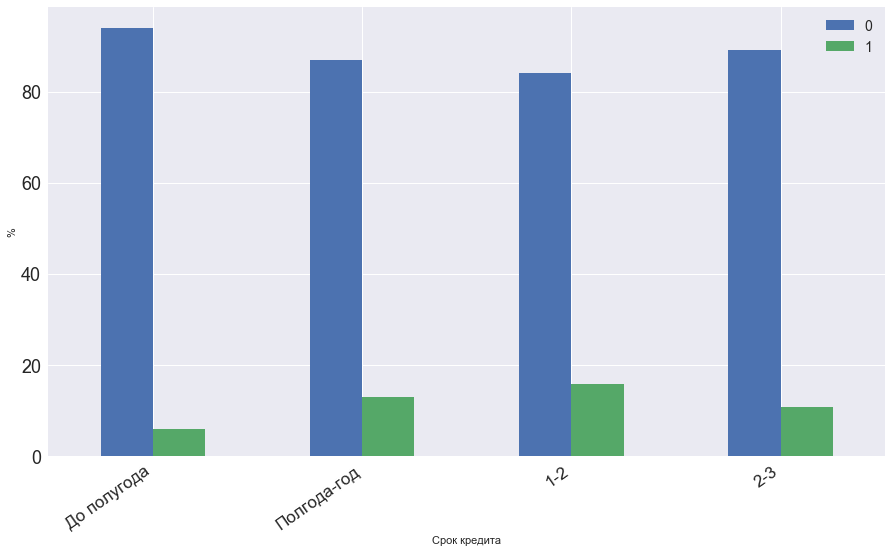

In [582]:
sns.set(rc={'figure.figsize':(15,8.27)})
bz.plot.bar()
# plt.plot(bz.reset_index(level=-1,drop=True), bz.reset_index(level=-1,drop=True).iloc[:,1],color = 'orange',linewidth=4.0)
# plt.show()
plt.yticks(fontsize=18)
plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')

In [556]:
bz=df.groupby(['Срок кредита','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack(level=-1).fillna(0)
print(df.groupby(['Срок кредита','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack().fillna(0))

Флаг дефолта по кредиту    0    1
Срок кредита                     
До полугода              496   32
Полгода-год              726  109
1-2                      264   50
2-3                       41    5


Флаг дефолта по кредиту      0     1
Тип товара Срок кредита             
0          До полугода     9.0   1.0
           Полгода-год     4.0   2.0
           1-2             4.0   0.0
           2-3             1.0   0.0
1          До полугода     4.0   0.0
           Полгода-год     3.0   0.0
           1-2             2.0   0.0
2          До полугода   136.0   4.0
           Полгода-год   202.0  16.0
           1-2            94.0  15.0
           2-3             3.0   1.0
3          До полугода     1.0   0.0
           2-3             1.0   0.0
4          До полугода    62.0   0.0
           Полгода-год    91.0   6.0
           1-2            17.0   2.0
5          Полгода-год     8.0   1.0
           1-2            32.0   4.0
           2-3            10.0   0.0
6          До полугода    58.0   0.0
           Полгода-год    67.0   5.0
           1-2            28.0   1.0
           2-3             3.0   2.0
7          До полугода     3.0   0.0
           Полгода-год    13.0   0.0
 

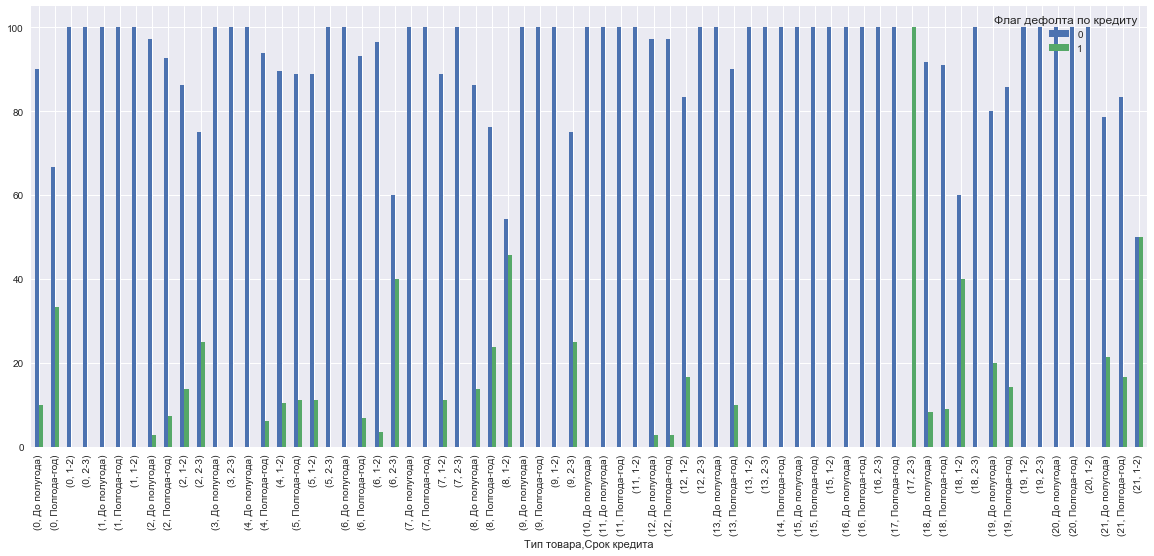

In [535]:
sns.set(rc={'figure.figsize':(20,8.10)})
bz=df.groupby(['Тип товара','Срок кредита','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().groupby(level=[0,1]).apply(lambda x: 100 * x / float(x.sum())).unstack(level=-1).fillna(0)
print(df.groupby(['Тип товара','Срок кредита','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack().fillna(0))
bz.plot.bar()

In [339]:
def_by_time=df[df['Флаг дефолта по кредиту']==1].groupby(['Срок кредита'])['Флаг дефолта по кредиту'].count().reset_index()
all_by_time=df.groupby(['Срок кредита'])['Флаг дефолта по кредиту'].count().reset_index()
all_by_time=all_by_time[all_by_time['Срок кредита'].isin(def_by_time['Срок кредита'])]
perc_def_by_time=def_by_time['Флаг дефолта по кредиту'].values/all_by_time['Флаг дефолта по кредиту'].values

In [396]:
df.columns

Index(['Месяц выдачи кредита', 'Сумма кредита', 'Срок кредита',
       'Возраст клиента', 'Пол клиента', 'Образование клиента', 'Тип товара',
       'Наличие детей у клиента', 'Регион выдачи кредита', 'Доход клиента',
       'Семейное положение', 'Оператор связи', 'Является ли клиентом банка',
       'Флаг дефолта по кредиту', 'Сбережения после отданной месячной нормы',
       'Сбережния/Зарплату', 'Месяц отдачи кредита',
       'Возраст клиента по категории'],
      dtype='object')

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <a list of 9 Text xticklabel objects>)

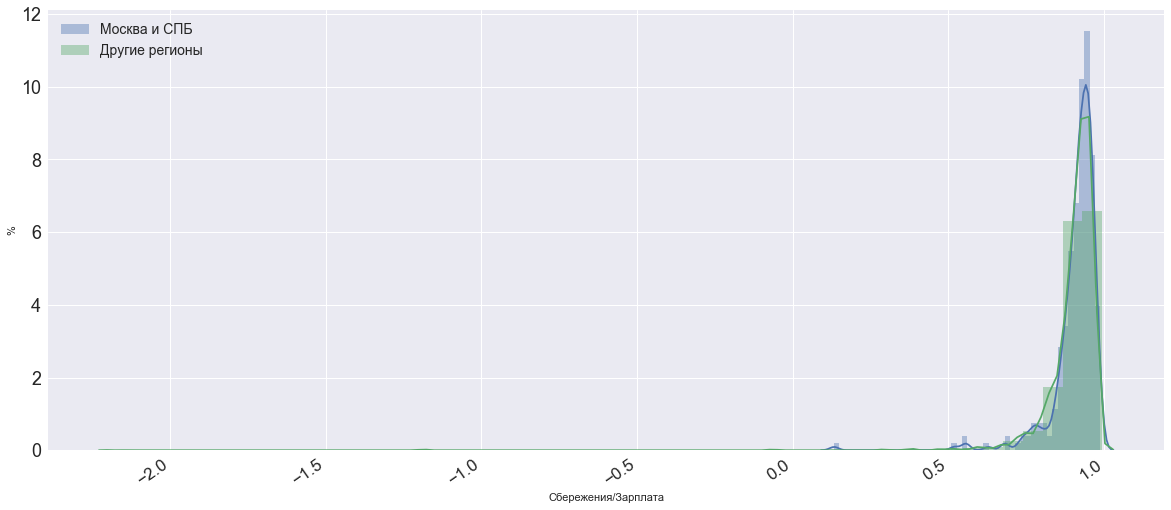

In [402]:
sns.set(rc={'figure.figsize':(20,8.10)})
plt.legend()
sns.distplot(df[df['Регион выдачи кредита']!=0]['Сбережения/Зарплата'],label='Москва и СПБ')
sns.distplot(df[df['Регион выдачи кредита']==0]['Сбережения/Зарплата'],label='Другие регионы')
plt.yticks(fontsize=18)
plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000.]), <a list of 9 Text xticklabel objects>)

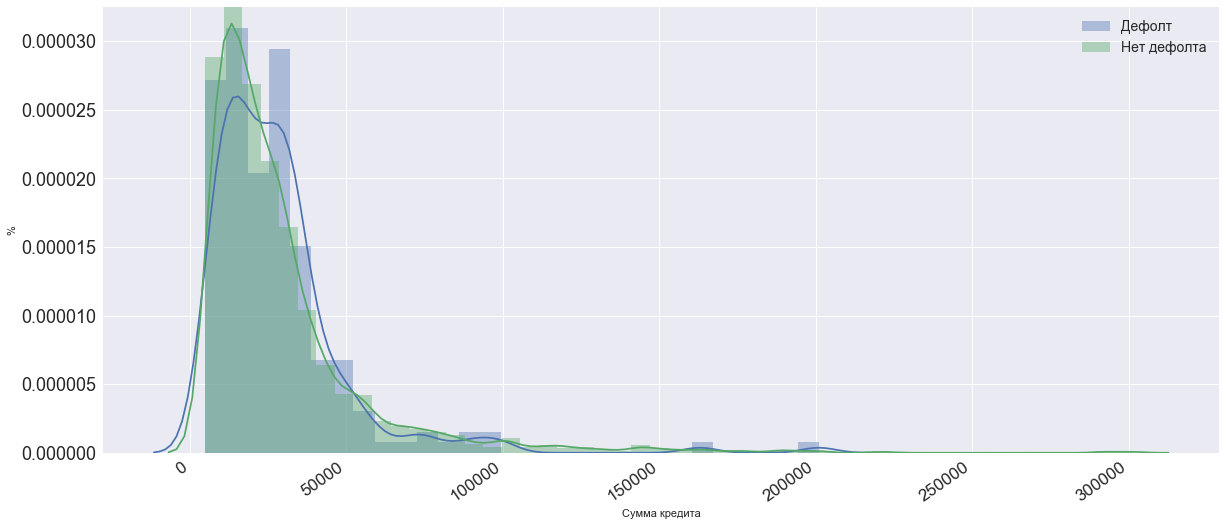

In [380]:
plt.legend()
sns.set(rc={'figure.figsize':(20,8.20)})
sns.distplot(df[df['Флаг дефолта по кредиту']==1]['Сумма кредита'],label='Дефолт')
sns.distplot(df[df['Флаг дефолта по кредиту']==0]['Сумма кредита'],label='Нет дефолта')
plt.yticks(fontsize=18)
plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')

In [341]:
perc_def_by_time

array([0.04255319, 0.05970149, 0.05555556, 0.06590258, 0.05555556,
       0.2       , 0.09178744, 0.15260323, 0.75      , 0.05660377,
       0.55555556, 0.22131148, 0.09917355, 1.        , 0.16666667,
       0.08108108])

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


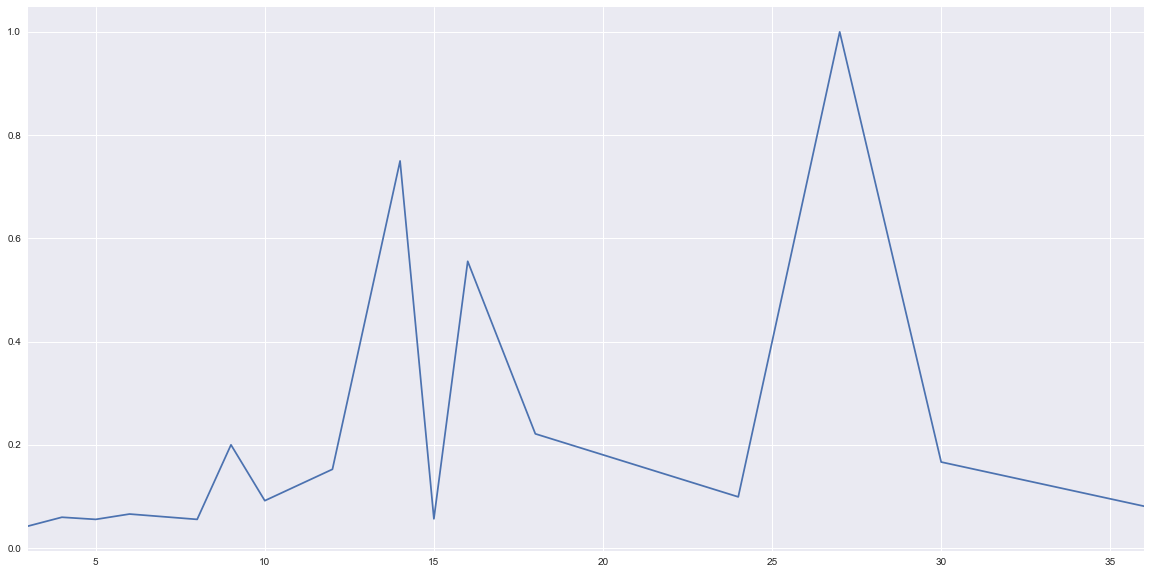

In [84]:
plt.legend()
sns.tsplot(time=def_by_time['Срок кредита'].values, data=perc_def_by_time)
# sns.tsplot(time=def_by_time['Срок кредита'].values, data=)

In [381]:
reg_dts_gr.loc[:,1]/reg_dts_gr.loc[:,0]

Другие регионы            0.137570
Москва или МО             0.095890
Санкт-Петербург или ЛО    0.061538
dtype: float64

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


([0, 1, 2], <a list of 3 Text xticklabel objects>)

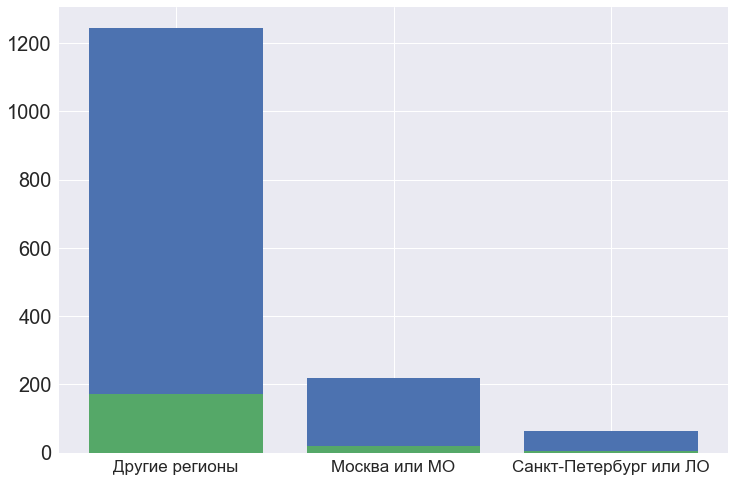

In [369]:
reg_dts_gr=df.groupby(['Регион выдачи кредита','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
sns.set(rc={'figure.figsize':(12,8.20)})
reg_dts_gr.index=d['Регион выдачи кредита'].inverse_transform(reg_dts_gr.index)
plt.legend(fontsize=14)
plt.bar(reg_dts_gr.index,reg_dts_gr.values[:,0])
plt.bar(reg_dts_gr.index,reg_dts_gr.values[:,1])
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.xticks(fontsize=17)

# ax.annotate(str(p.get_height()), (p.get_x() *1.005, p.get_height() * 1.005),fontsize=18,color='black', weight='semibold')

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Другие регионы            1414
Москва или МО              240
Санкт-Петербург или ЛО      69
Name: Регион выдачи кредита, dtype: int64


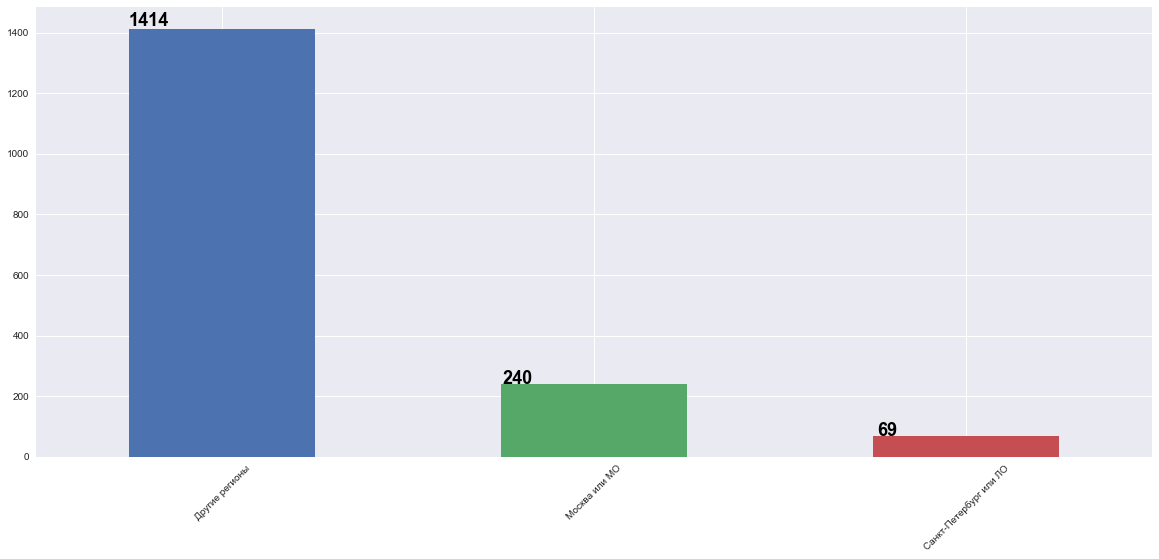

In [342]:
reg_dist=df['Регион выдачи кредита'].value_counts()
reg_dist.index=d['Регион выдачи кредита'].inverse_transform(reg_dist.index)
print(reg_dist)
ax=reg_dist.plot.bar(rot=45)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() *1.005, p.get_height() * 1.005),fontsize=18,color='black', weight='semibold')

In [305]:
def_by_ed

Флаг дефолта по кредиту,0,1
Неоконченное среднее,100.000000,0.000000
Среднее,80.769231,19.230769
Среднее специальное,86.124402,13.875598
Неоконченное высшее,94.186047,5.813953
Высшее,94.017094,5.982906
Несколько высших или более высокая ступень образования,100.000000,0.000000


In [413]:
def_by_ed.index.values

array(['Неоконченное среднее', 'Среднее', 'Среднее специальное',
       'Неоконченное высшее', 'Высшее',
       'Несколько высших или более высокая ступень образования'],
      dtype=object)

Неоконченное среднее                                       0.000000
Среднее                                                   19.230769
Среднее специальное                                       13.875598
Неоконченное высшее                                        5.813953
Высшее                                                     5.982906
Несколько высших или более высокая ступень образования     0.000000
Name: 1, dtype: float64


C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

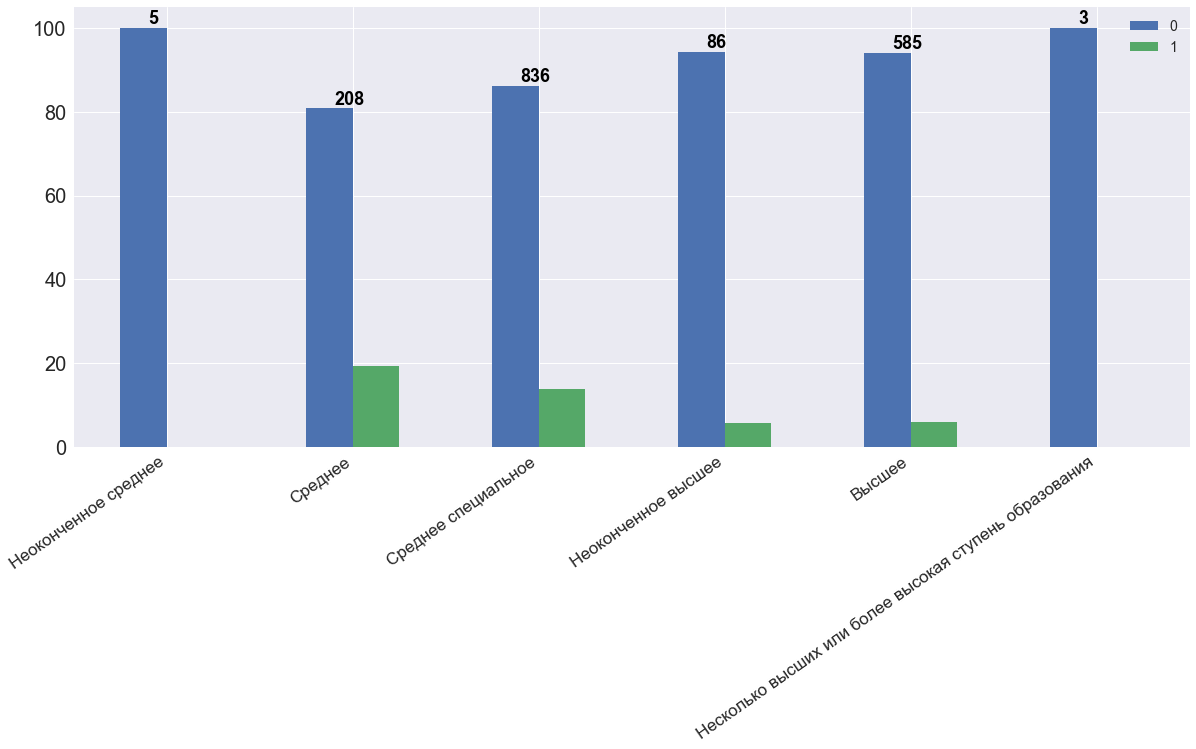

In [416]:
def_by_ed=df.groupby(['Образование клиента','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack(level=-1).fillna(0)
inv_map_dict_ed = {v: k for k, v in map_dict[0]['Образование клиента'].items()}
def_by_ed.index=[inv_map_dict_ed[i] for i in def_by_ed.index]
ed_count=df['Образование клиента'].value_counts()
ed_count.index=d['Образование клиента'].inverse_transform(ed_count.index)
# def_by_ed.index=d['Образование клиента'].inverse_transform(def_by_ed.index)
print(def_by_ed.iloc[:,1])
ed_count=ed_count.sort_index()
def_by_ed.plot.bar(rot=45)
for i in range(0,len(def_by_ed.index)):
    plt.text(-0.1+i, max(def_by_ed.iloc[i])+1, ed_count.values[i], horizontalalignment='left', fontsize='18', color='black', weight='semibold')
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')
# plt.plot(def_by_ed.index.values, def_by_ed.iloc[:,1].values,color = 'orange',linewidth=4.0)

In [437]:
def_by_age.index()

TypeError: 'CategoricalIndex' object is not callable

Возраст клиента по категории
Юно-ий возраст    36.363636
Взрослые          26.277372
Зрелые            22.448980
Пенсионеры         7.567568
Name: percent, dtype: float64


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

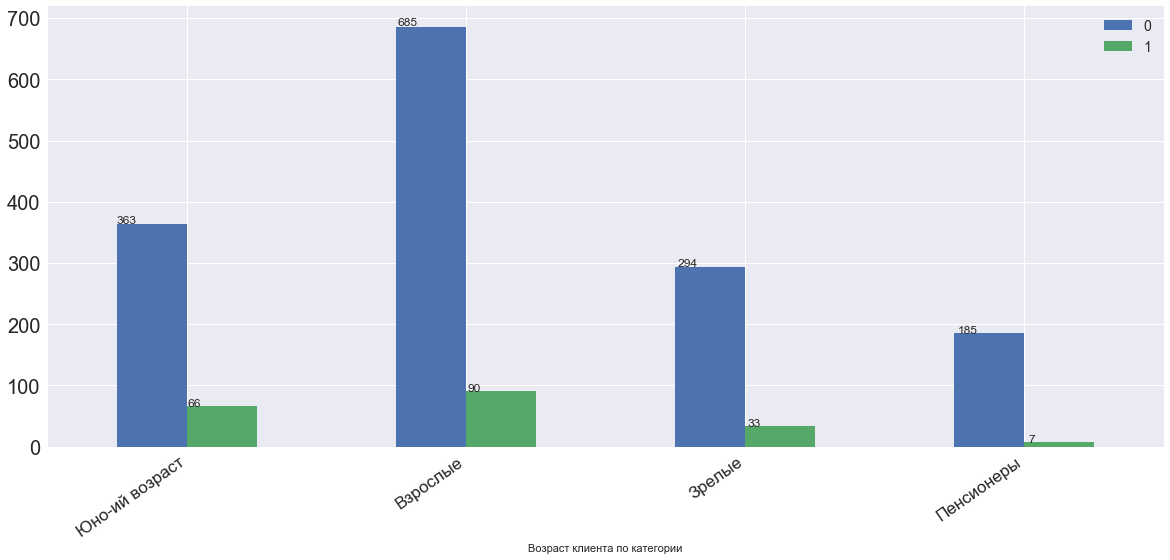

In [442]:
df['Возраст клиента по категории']=pd.cut(df['Возраст клиента'],bins=[0,11,17,25,40,54,100],right=True ,labels=['Детсад','Школьники','Юно-ий возраст','Взрослые','Зрелые','Пенсионеры'])
def_by_age=df.groupby(['Возраст клиента по категории','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack().fillna(0)
cat_index=def_by_age.iloc[:,0:2].index
def_by_age.reset_index(drop=True,inplace=True)
def_by_age.index=cat_index
def_by_age['percent']=def_by_age.loc[:,1].values/def_by_age.loc[:,0].values*100*2
def_by_age['percent'].replace(np.inf,0,inplace=True)
print(def_by_age['percent'])
ax=def_by_age.iloc[:,0:2].plot.bar()
# plt.plot(def_by_age.index, def_by_age['percent'],color = 'orange',linewidth=4.0)
n=0
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    n+=1
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')

Женский    34.319527
Мужской    18.801410
Name: percent, dtype: float64


C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1]), <a list of 2 Text xticklabel objects>)

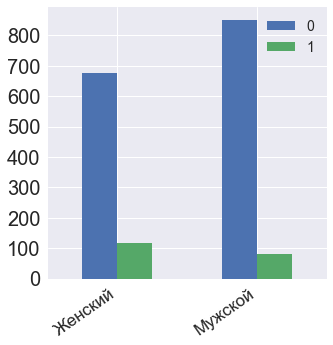

In [599]:
sns.set(rc={'figure.figsize':(5,5)})
def_by_gender=df.groupby(['Пол клиента','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
def_by_gender.index=d['Пол клиента'].inverse_transform(def_by_gender.index)
def_by_gender['percent']=def_by_gender.loc[:,1].values/def_by_gender.loc[:,0].values*100*2
def_by_gender['percent'].replace(np.inf,0,inplace=True)
print(def_by_gender['percent'])
def_by_gender.iloc[:,:2].plot.bar()
# plt.plot(def_by_gender.index, def_by_gender['percent'],color = 'orange',linewidth=4.0)
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=35, ha='right')

In [311]:
def_by_inside

Флаг дефолта по кредиту,0,1,percent
Клиент банка,630,51,8.095238
Не клиент банка,897,145,16.164994


In [459]:
d['Является ли клиентом банка'].classes_

array(['Клиент банка', 'Не клиент банка'], dtype=object)

In [452]:
df_original.groupby(['Является ли клиентом банка'])['Флаг дефолта по кредиту'].value_counts()

Является ли клиентом банка  Флаг дефолта по кредиту
Клиент банка                Нет дефолта                897
                            Дефолт                     145
Не клиент банка             Нет дефолта                630
                            Дефолт                      51
Name: Флаг дефолта по кредиту, dtype: int64

Не клиент банка     8.095238
Клиент банка       16.164994
Name: percent, dtype: float64


(array([0, 1]), <a list of 2 Text xticklabel objects>)

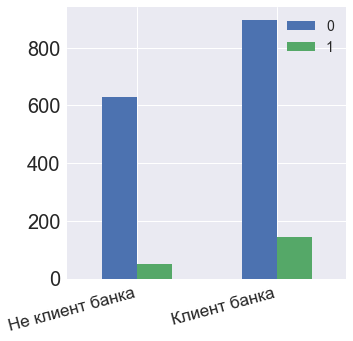

In [480]:
sns.set(rc={'figure.figsize':(5,5)})
def_by_inside=df.groupby(['Является ли клиентом банка','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
def_by_inside['percent']=def_by_inside.loc[:,1].values/def_by_inside.loc[:,0].values*100
def_by_inside['percent'].replace(np.inf,0,inplace=True)
inv_map_dict_inside = {v: k for k, v in map_dict[0]['Является ли клиентом банка'].items()}
def_by_inside.index=[inv_map_dict_inside[i] for i in def_by_inside.index]
print(def_by_inside['percent'])
# def_by_inside.index=d['Является ли клиентом банка'].inverse_transform(def_by_inside.index)
def_by_inside.iloc[:,:2].plot.bar()
# plt.plot(def_by_inside.index, def_by_inside['percent'],color = 'orange',linewidth=4.0)
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=15, ha='right')

Другое                             11.617100
Женат/замужем                      16.230366
Никогда не был(а) женат/замужем    13.043478
Name: percent, dtype: float64


C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

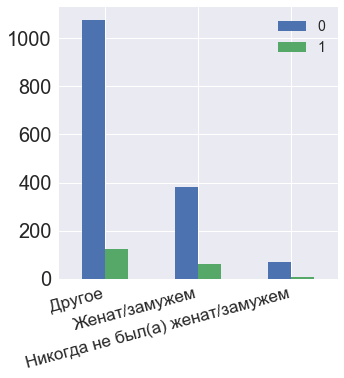

In [481]:
def_by_marital=df.groupby(['Семейное положение','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
def_by_marital.index=d['Семейное положение'].inverse_transform(def_by_marital.index)
def_by_marital['percent']=def_by_marital.loc[:,1].values/def_by_marital.loc[:,0].values*100
def_by_marital['percent'].replace(np.inf,0,inplace=True)
print(def_by_marital['percent'])
# def_by_marital.index=d['Является ли клиентом банка'].inverse_transform(def_by_marital.index)
def_by_marital.iloc[:,:2].plot.bar()
# plt.plot(def_by_marital.index, def_by_marital['percent'],color = 'orange',linewidth=4.0)
# def_by_inside.plot.barh()
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=15, ha='right')

Детей нет    30.140187
Дети есть    19.970194
Name: percent, dtype: float64


C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0, 1]), <a list of 2 Text xticklabel objects>)

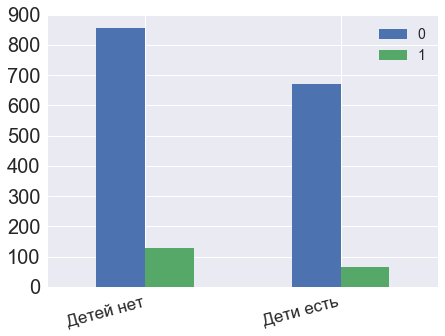

In [479]:
def_by_child=df.groupby(['Наличие детей у клиента','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
def_by_child.index=d['Наличие детей у клиента'].inverse_transform(def_by_child.index)
def_by_child['percent']=def_by_child.loc[:,1].values/def_by_child.loc[:,0].values*100*2
def_by_child['percent'].replace(np.inf,0,inplace=True)
print(def_by_child['percent'])
# def_by_child.index=d['Является ли клиентом банка'].inverse_transform(def_by_child.index)
def_by_child.iloc[:,:2].plot.bar()
# plt.plot(def_by_child.index, def_by_child['percent'],color = 'orange',linewidth=4.0)
# def_by_inside.plot.barh()
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17,rotation=15, ha='right')

In [600]:
def_by_child.iloc[:,1]

Семейное положение  Наличие детей у клиента
0                   0                          82
                    1                          43
1                   0                          41
                    1                          21
2                   0                           6
                    1                           3
Name: 1, dtype: int64

Семейное положение  Наличие детей у клиента
0                   0                          0.135987
                    1                          0.090909
1                   0                          0.189815
                    1                          0.126506
2                   0                          0.162162
                    1                          0.093750
dtype: float64


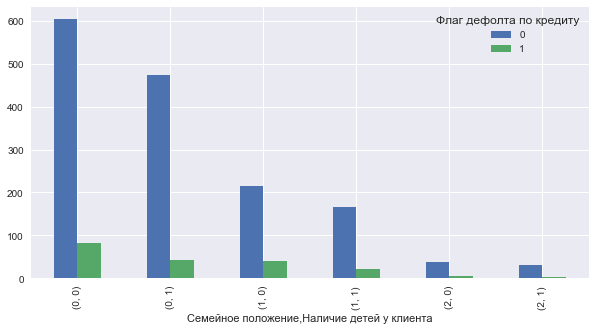

In [494]:
sns.set(rc={'figure.figsize':(10,5)})
def_by_child=df.groupby(['Семейное положение','Наличие детей у клиента','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
print(def_by_child.iloc[:,1]/def_by_child.iloc[:,0])
def_by_child.plot.bar()

# def_by_child.index=d['Наличие детей у клиента'].inverse_transform(def_by_child.index)
# def_by_child['percent']=def_by_child.loc[:,1].values/def_by_child.loc[:,0].values*100*2
# def_by_child['percent'].replace(np.inf,0,inplace=True)
# print(def_by_child['percent'])
# # def_by_child.index=d['Является ли клиентом банка'].inverse_transform(def_by_child.index)
# def_by_child.iloc[:,:2].plot.bar()
# # plt.plot(def_by_child.index, def_by_child['percent'],color = 'orange',linewidth=4.0)
# # def_by_inside.plot.barh()
# plt.yticks(fontsize=20)
# # plt.ylabel('%')
# plt.legend(fontsize=14)
# plt.xticks(fontsize=17,rotation=15, ha='right')

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


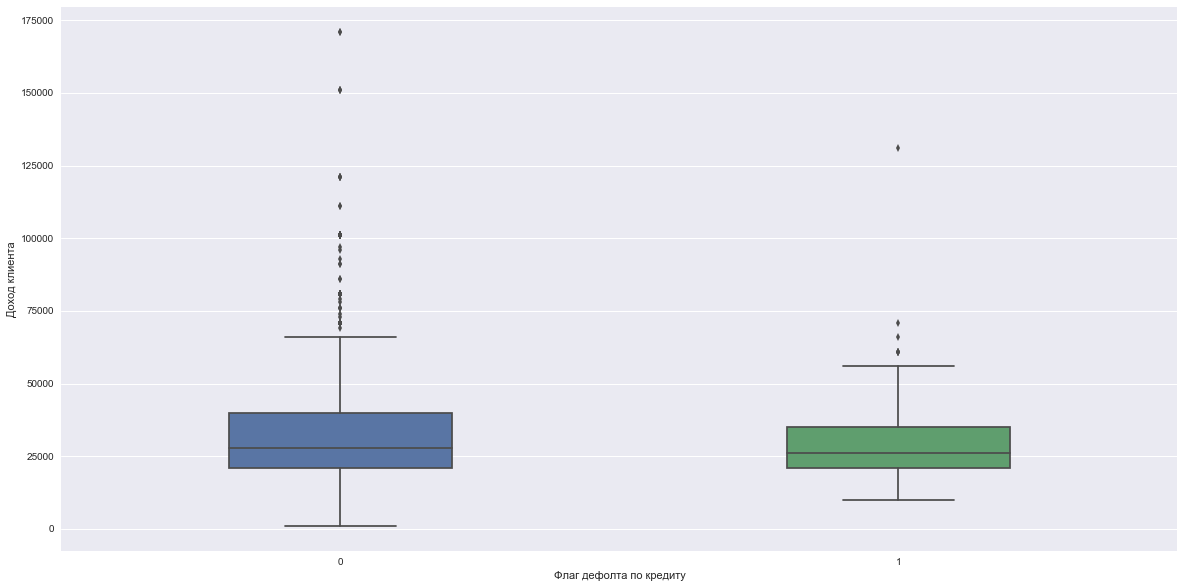

In [321]:
df_upd_sal=df[df['Доход клиента']<200000]
sns.boxplot(data=df_upd_sal,x='Флаг дефолта по кредиту',y='Доход клиента',width=0.4)

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


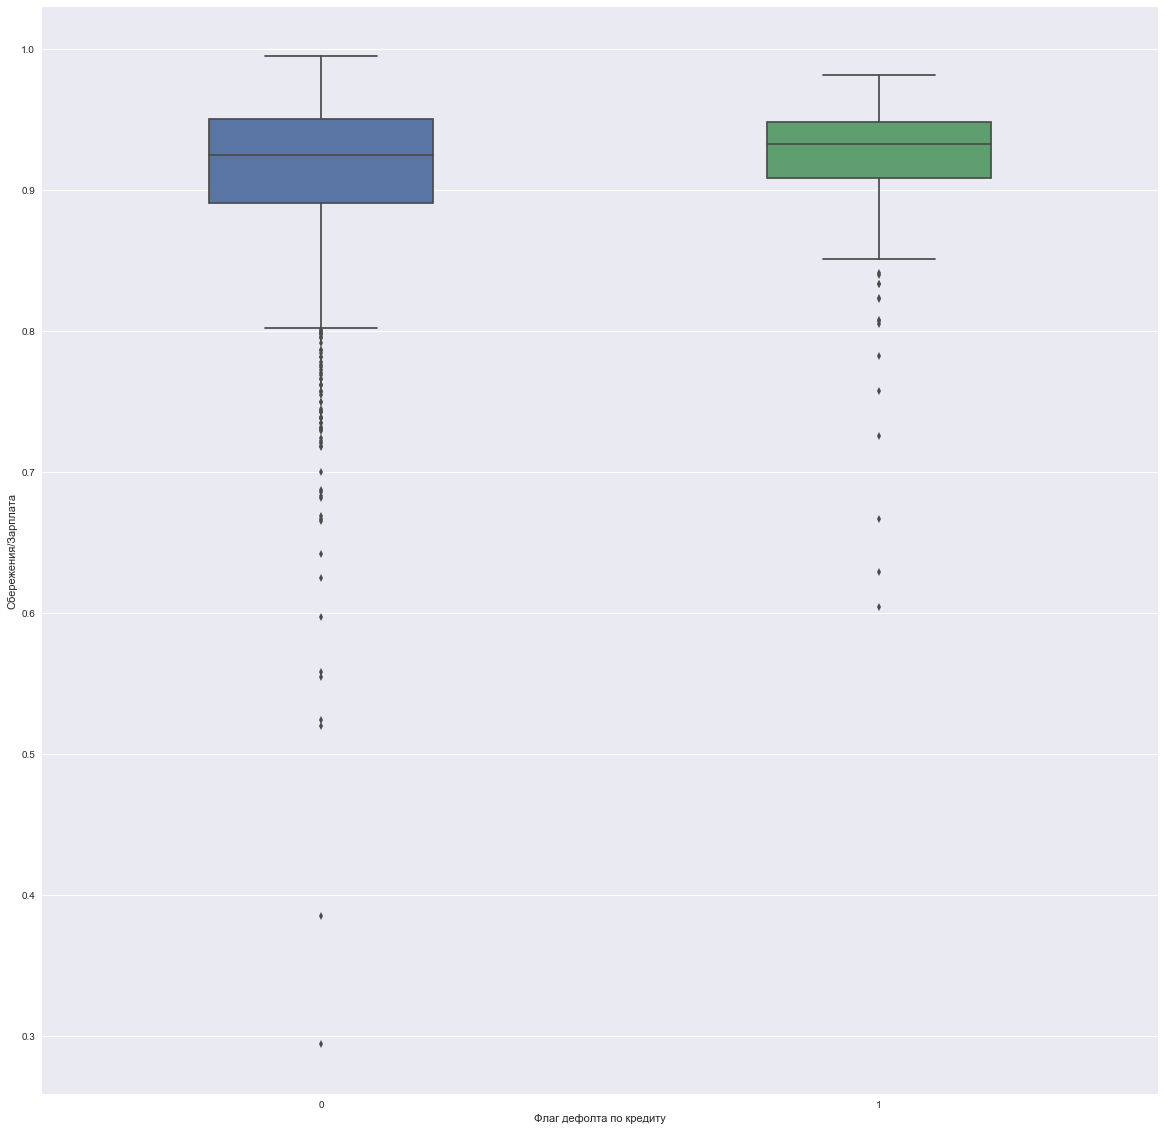

In [507]:
df_upd_sal=df[df['Возраст клиента']<55].copy()
sns.boxplot(data=df_upd_sal,x='Флаг дефолта по кредиту',y='Сбережения/Зарплата',width=0.4)

Пенсионеры отдают с пенсии! Даешь больше кредитов пенсионерам!!!

In [587]:
df[['Возраст клиента','Сбережения после отданной месячной нормы']].sort_values('Сбережения после отданной месячной нормы').head(10)

,Возраст клиента,Сбережения после отданной месячной нормы
1480,76,-2194.444444
1075,63,-1187.500000
514,56,-125.000000
1149,60,2000.000000
1275,60,4250.000000
573,57,4833.333333
178,33,5125.000000
141,29,5375.000000
927,20,5416.666667
1687,76,5583.333333


In [426]:
df[df['Возраст клиента']>=55]['Флаг дефолта по кредиту'].value_counts()

0    185
1      7
Name: Флаг дефолта по кредиту, dtype: int64

In [368]:
df.groupby(['Месяц выдачи кредита','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack(level=-1)

Флаг дефолта по кредиту,0,1
Месяц выдачи кредита,,
1,86.330935,13.669065
2,92.753623,7.246377
3,86.075949,13.924051
4,90.076336,9.923664
5,88.793103,11.206897
6,88.524590,11.475410
7,93.793103,6.206897
8,87.323944,12.676056
9,90.441176,9.558824


In [371]:
df.groupby(['Месяц отдачи кредита','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack(level=-1)

Флаг дефолта по кредиту,0,1
Месяц отдачи кредита,,
0,87.012987,12.987013
1,91.791045,8.208955
2,88.356164,11.643836
3,81.379310,18.620690
4,90.000000,10.000000
5,87.096774,12.903226
6,89.516129,10.483871
7,89.937107,10.062893
8,87.421384,12.578616


In [495]:
df.groupby(['Оператор связи','Является ли клиентом банка','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
# def_by_telecom.index=d['Оператор связи'].inverse_transform(def_by_telecom.index)
# def_by_telecom['percent']=def_by_telecom.loc[:,1].values/def_by_telecom.loc[:,0].values*100
# def_by_telecom['percent'].replace(np.inf,0,inplace=True)
# print(def_by_telecom['percent'])
# # def_by_telecom.index=d['Является ли клиентом банка'].inverse_transform(def_by_telecom.index)
# def_by_telecom.iloc[:,:2].plot.bar()
# plt.plot(def_by_telecom.index, def_by_telecom['percent'],color = 'orange',linewidth=4.0)
# # def_by_inside.plot.barh()

Флаг дефолта по кредиту                      0   1
Оператор связи Является ли клиентом банка         
0              0                           118   8
               1                           171  20
1              0                             7   1
               1                            17   2
2              0                           191  14
               1                           279  52
3              0                           248  25
               1                           337  56
4              0                            66   3
               1                            93  15

Билайн      9.688581
Другой     12.500000
МТС        14.042553
Мегафон    13.846154
Теле2      11.320755
Name: percent, dtype: float64


C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


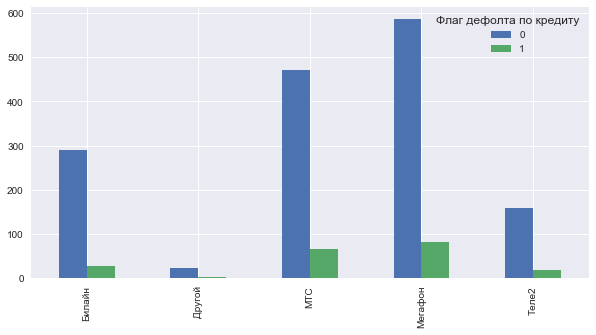

In [497]:
def_by_telecom=df.groupby(['Оператор связи','Флаг дефолта по кредиту'])['Флаг дефолта по кредиту'].count().unstack()
def_by_telecom.index=d['Оператор связи'].inverse_transform(def_by_telecom.index)
def_by_telecom['percent']=def_by_telecom.loc[:,1].values/def_by_telecom.loc[:,0].values*100
def_by_telecom['percent'].replace(np.inf,0,inplace=True)
print(def_by_telecom['percent'])
# def_by_telecom.index=d['Является ли клиентом банка'].inverse_transform(def_by_telecom.index)
def_by_telecom.iloc[:,:2].plot.bar()
# plt.plot(def_by_telecom.index, def_by_telecom['percent'],color = 'orange',linewidth=4.0)
# def_by_inside.plot.barh()

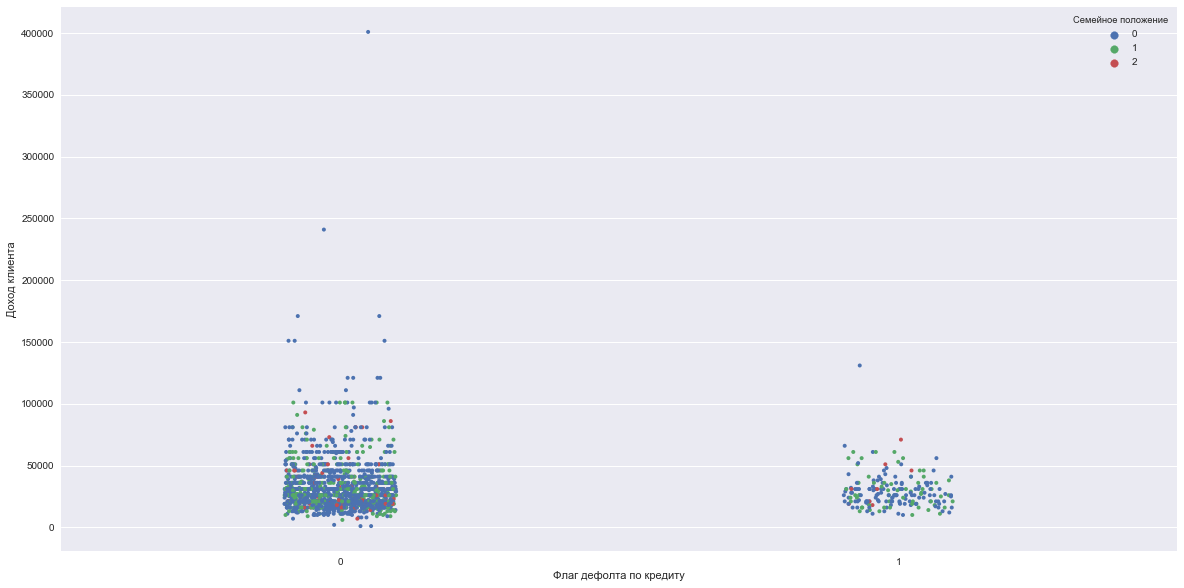

In [480]:
sns.stripplot(x='Флаг дефолта по кредиту',jitter=True,data=df,y='Доход клиента',size=4,hue='Семейное положение')

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


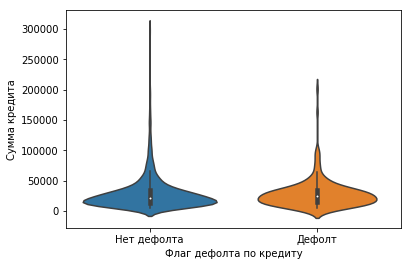

In [55]:
sns.violinplot(df['Флаг дефолта по кредиту'],df['Сумма кредита'])

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


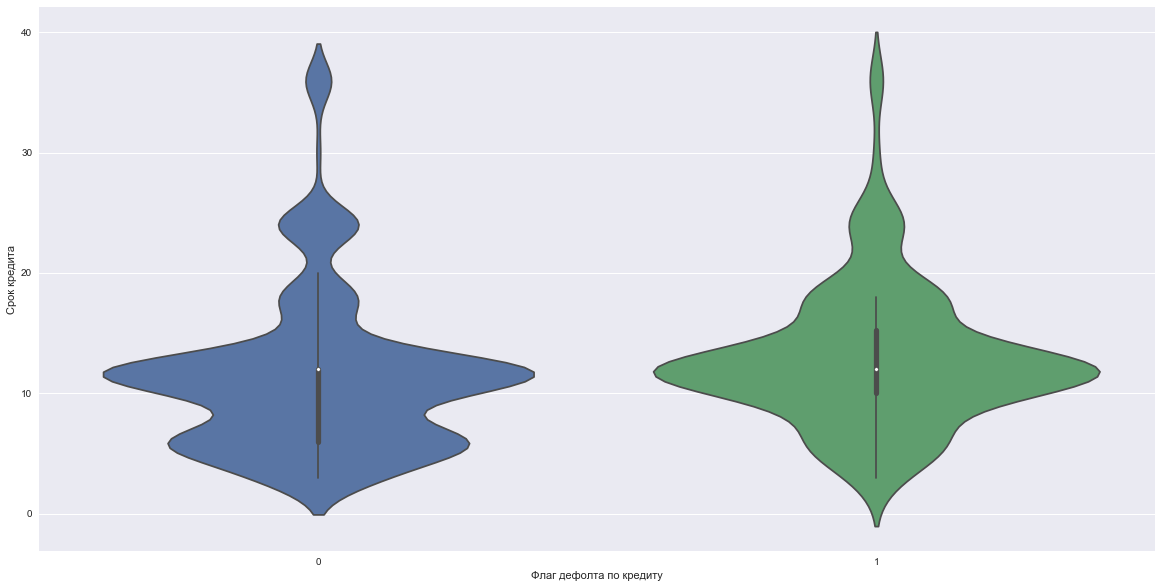

In [202]:
sns.violinplot(df['Флаг дефолта по кредиту'],df['Срок кредита'])

In [428]:
inv_map_dict_ed = {v: k for k, v in map_dict[0]['Образование клиента'].items()}
# def_by_ed.index=[inv_map_dict_ed[i] for i in def_by_ed.index]
df['Образование клиента']=df['Образование клиента'].replace(inv_map_dict_ed)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text xticklabel objects>)

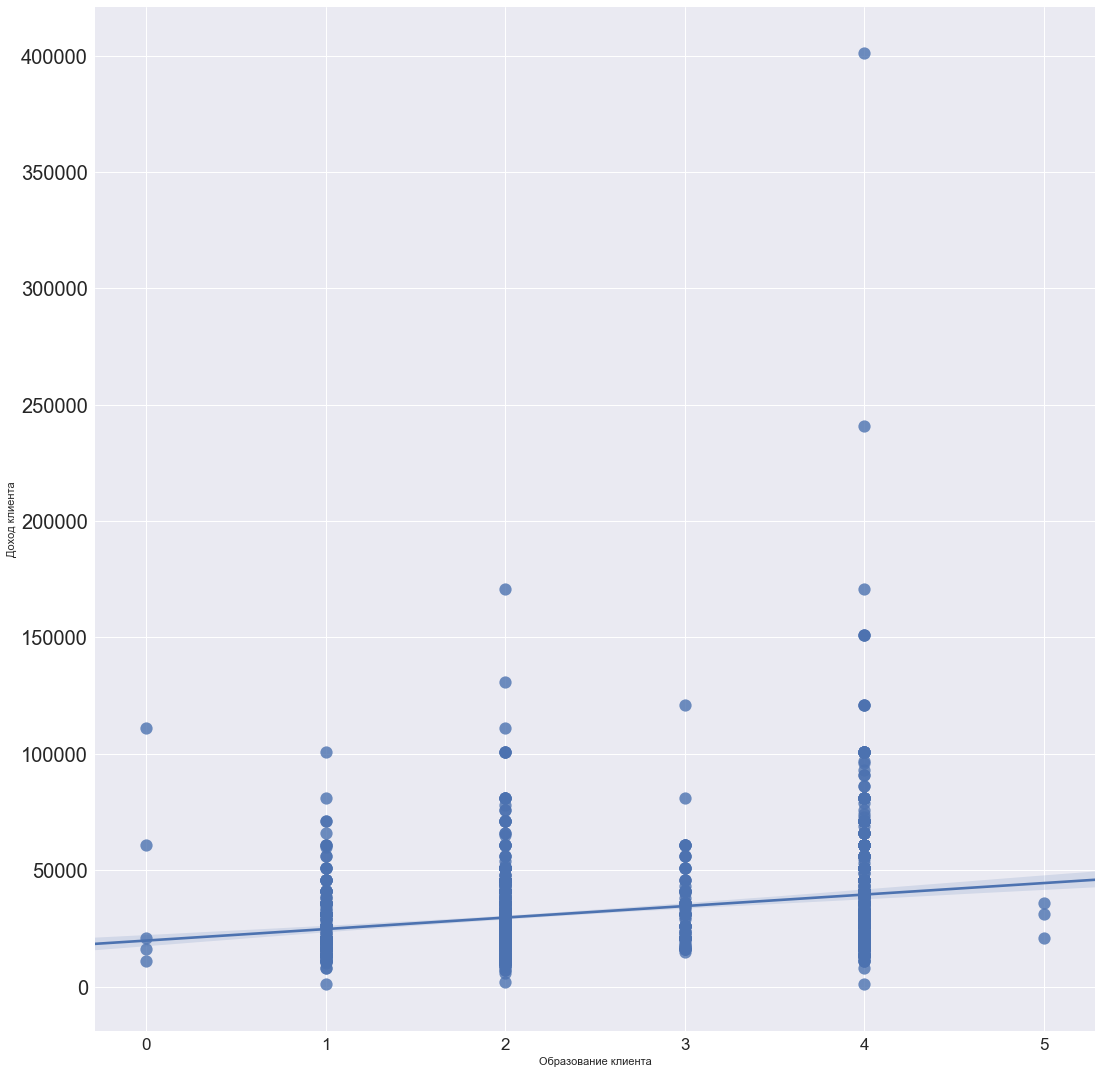

In [434]:
sns.lmplot(x='Образование клиента', y='Доход клиента', data=df,fit_reg=True ,size=15,scatter_kws={"s": 150})
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=17)

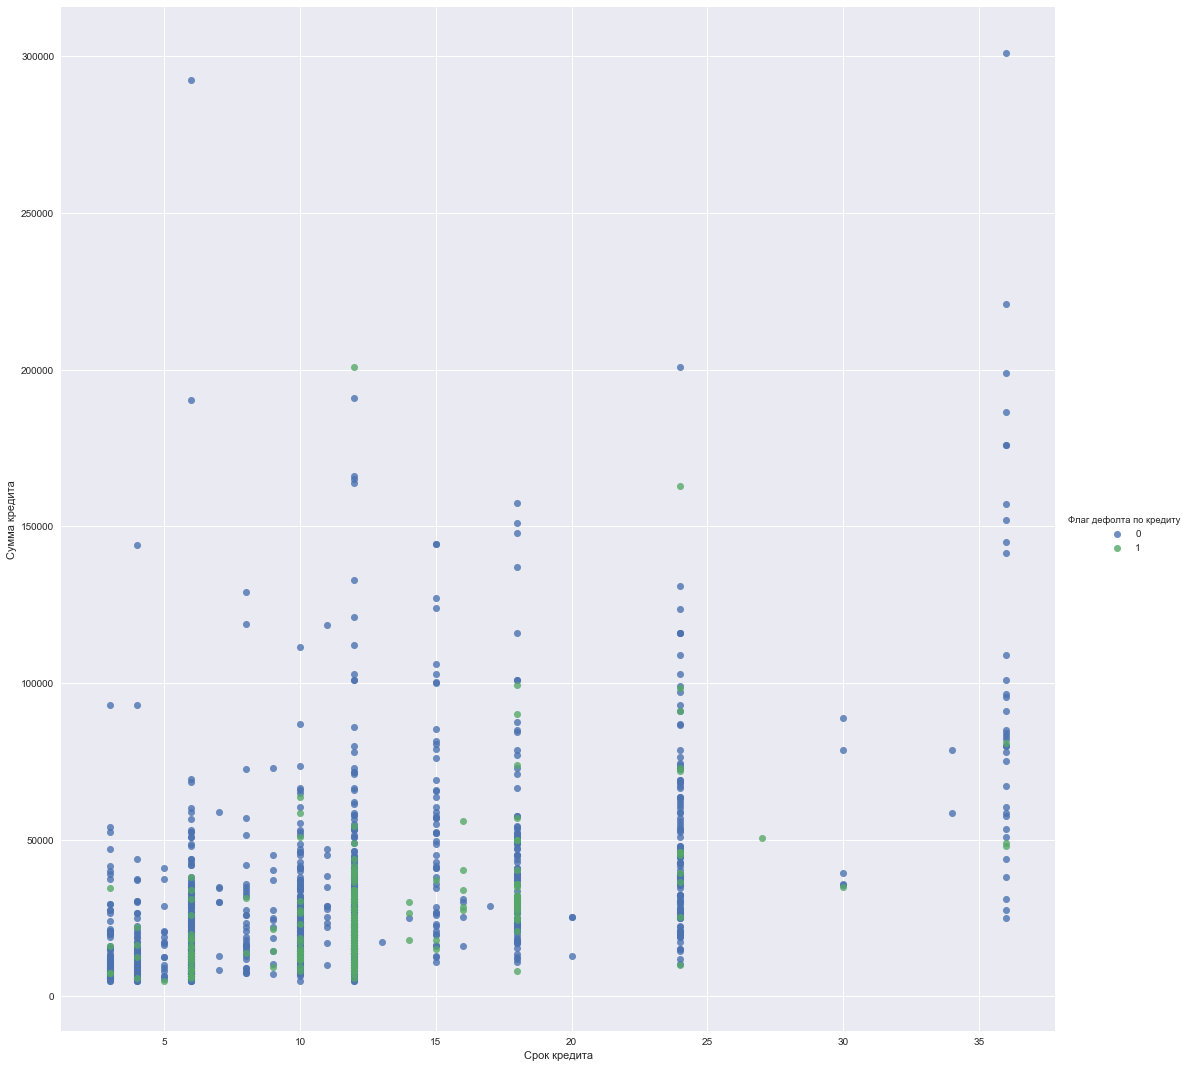

In [331]:
sns.lmplot(x='Срок кредита', y='Сумма кредита', data=df,fit_reg=False, hue='Флаг дефолта по кредиту',size=15,scatter_kws={"s": 50})

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:895: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:915: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


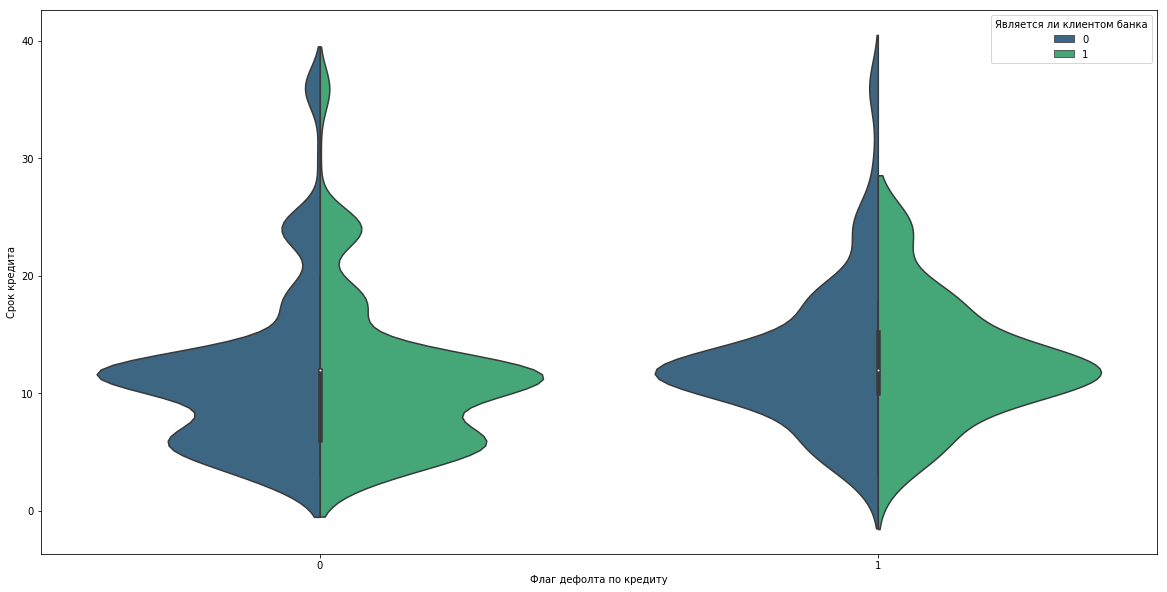

In [95]:
sns.violinplot(df['Флаг дефолта по кредиту'],df['Срок кредита'],scale='width',
               hue=df['Является ли клиентом банка'],split=True,palette="viridis")

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 <a list of 17 Text xticklabel objects>)

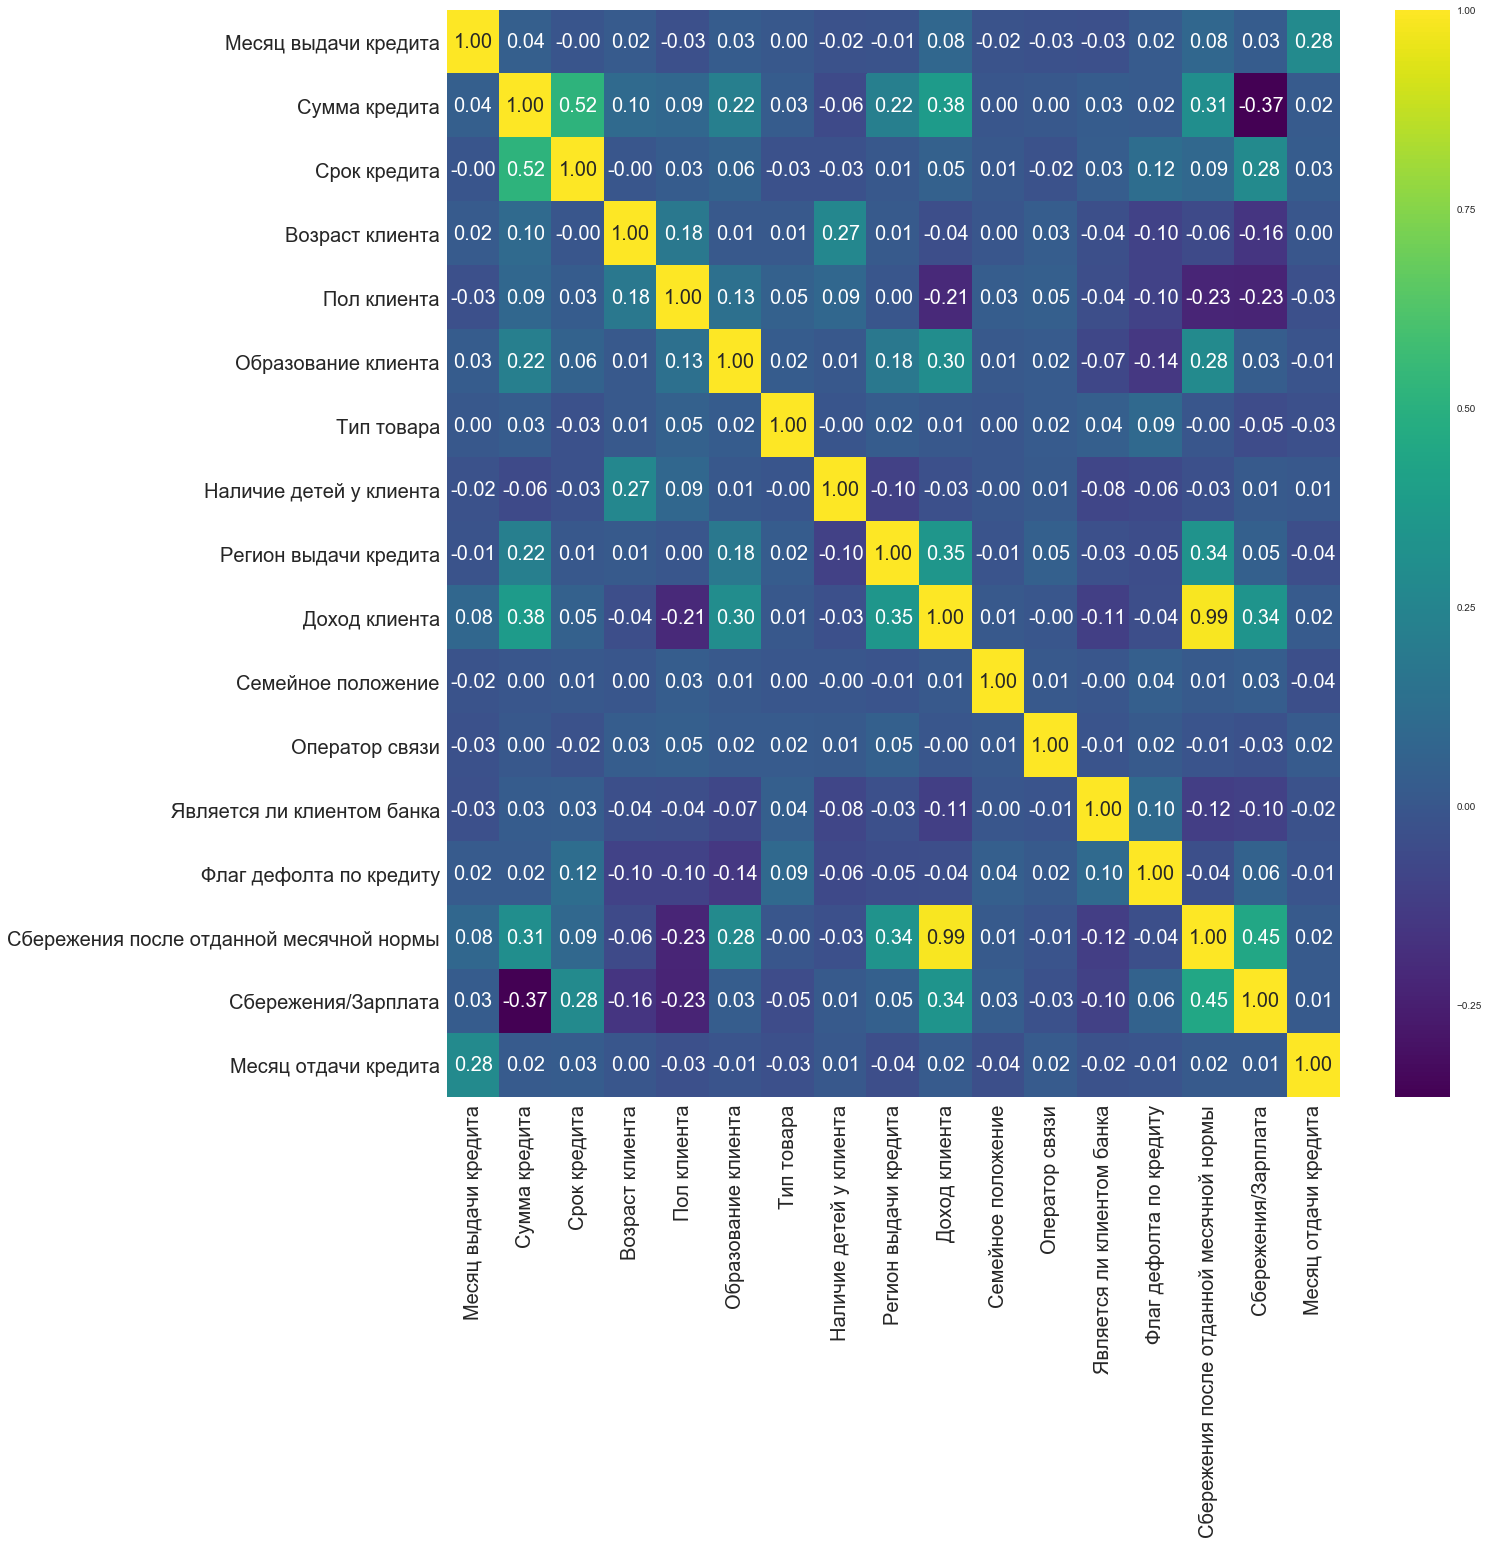

In [506]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df.corr(method='spearman'),fmt='.2f',annot=True,cmap="viridis",annot_kws={"size": 20})
plt.yticks(fontsize=20)
# plt.ylabel('%')
plt.legend(fontsize=14)
plt.xticks(fontsize=20)

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


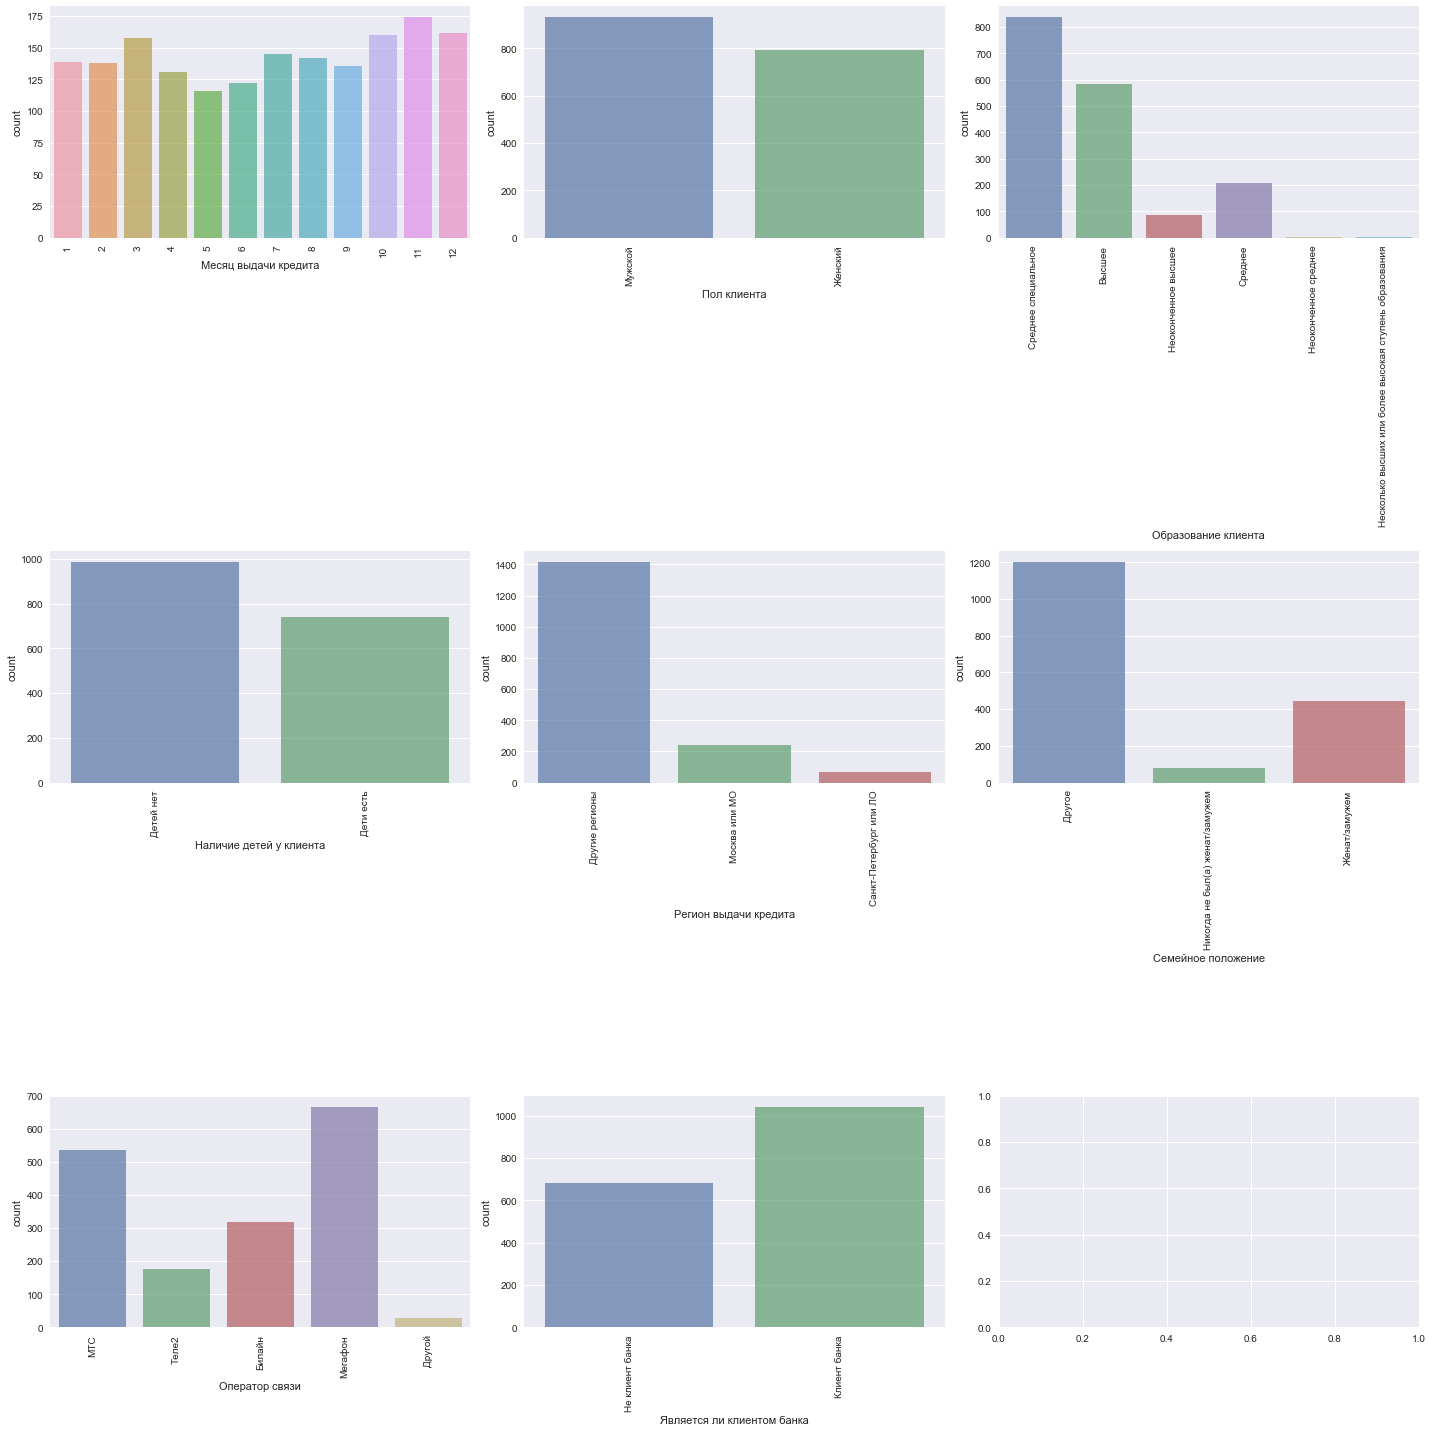

In [507]:
categorical_columns=['Месяц выдачи кредита','Пол клиента','Образование клиента','Наличие детей у клиента','Регион выдачи кредита','Семейное положение','Оператор связи','Является ли клиентом банка']
fig, axes = plt.subplots(round(len(df_original[categorical_columns].columns) / 3), 3, figsize=(20, 20))

for i, ax in enumerate(fig.axes):
    if i < len(df_original[categorical_columns].columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
#         print (ax.get_xticklabels().get_xticklabels)
        sns.countplot(x=df_original[categorical_columns].columns[i], alpha=0.7, data=df_original[categorical_columns], ax=ax)

fig.tight_layout()

In [175]:
clf=RandomForestClassifier(n_estimators=30, max_depth=3,n_jobs=-1)
clf.fit(df.iloc[:,0:len(df.columns)-1],df.iloc[:,-1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [181]:
clf2=XGBClassifier()
clf2.fit(df.iloc[:,0:len(df.columns)-1],df.iloc[:,-1])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [183]:
list(zip(df.columns[:-2],clf2.feature_importances_))

[('Месяц выдачи кредита', 0.05930807),
 ('Сумма кредита', 0.17627677),
 ('Срок кредита', 0.12685338),
 ('Возраст клиента', 0.16144976),
 ('Пол клиента', 0.031301484),
 ('Образование клиента', 0.0461285),
 ('Тип товара', 0.15156507),
 ('Наличие детей у клиента', 0.014827018),
 ('Регион выдачи кредита', 0.021416804),
 ('Доход клиента', 0.10214168),
 ('Семейное положение', 0.03294893),
 ('Оператор связи', 0.03294893)]

In [180]:
from xgboost import XGBClassifier

In [176]:
list(zip(df.columns[:-2],clf.feature_importances_))

[('Месяц выдачи кредита', 0.041002375248153644),
 ('Сумма кредита', 0.06673419893481701),
 ('Срок кредита', 0.2137130149519349),
 ('Возраст клиента', 0.08381503225129268),
 ('Пол клиента', 0.08654924463645933),
 ('Образование клиента', 0.14812531448361116),
 ('Тип товара', 0.2174797546998438),
 ('Наличие детей у клиента', 0.009893620093351766),
 ('Регион выдачи кредита', 0.0037204790385493122),
 ('Доход клиента', 0.05699287240274944),
 ('Семейное положение', 0.023809688185638896),
 ('Оператор связи', 0.020738867166572188)]

In [11]:
['!dot -Tpng'+' small_tree_max_depth_'+str(i)+'.dot'' -o ' 'small_tree_max_depth_'+str(i)+'.png' for i in range(0,22)]

['!dot -Tpng small_tree_max_depth_0.dot -o small_tree_max_depth_0.png',
 '!dot -Tpng small_tree_max_depth_1.dot -o small_tree_max_depth_1.png',
 '!dot -Tpng small_tree_max_depth_2.dot -o small_tree_max_depth_2.png',
 '!dot -Tpng small_tree_max_depth_3.dot -o small_tree_max_depth_3.png',
 '!dot -Tpng small_tree_max_depth_4.dot -o small_tree_max_depth_4.png',
 '!dot -Tpng small_tree_max_depth_5.dot -o small_tree_max_depth_5.png',
 '!dot -Tpng small_tree_max_depth_6.dot -o small_tree_max_depth_6.png',
 '!dot -Tpng small_tree_max_depth_7.dot -o small_tree_max_depth_7.png',
 '!dot -Tpng small_tree_max_depth_8.dot -o small_tree_max_depth_8.png',
 '!dot -Tpng small_tree_max_depth_9.dot -o small_tree_max_depth_9.png',
 '!dot -Tpng small_tree_max_depth_10.dot -o small_tree_max_depth_10.png',
 '!dot -Tpng small_tree_max_depth_11.dot -o small_tree_max_depth_11.png',
 '!dot -Tpng small_tree_max_depth_12.dot -o small_tree_max_depth_12.png',
 '!dot -Tpng small_tree_max_depth_13.dot -o small_tree_max

In [23]:
df.columns

Index(['Месяц выдачи кредита', 'Сумма кредита', 'Срок кредита',
       'Возраст клиента', 'Пол клиента', 'Образование клиента', 'Тип товара',
       'Наличие детей у клиента', 'Регион выдачи кредита', 'Доход клиента',
       'Семейное положение', 'Оператор связи', 'Является ли клиентом банка',
       'Флаг дефолта по кредиту', 'Сбережения после отданной месячной нормы',
       'Сбережния/Зарплату', 'Месяц отдачи кредита',
       'Возраст клиента по категории'],
      dtype='object')

In [52]:
# df[df[category]==8]
map_dict[0]['Семейное положение']

{'Другое': 0, 'Женат/замужем': 1, 'Никогда не был(а) женат/замужем': 2}

In [57]:
df[df['Семейное положение']==2][df['Тип товара']==21]['Флаг дефолта по кредиту'].value_counts()

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0    3
Name: Флаг дефолта по кредиту, dtype: int64

In [35]:
dt_clf=DecisionTreeClassifier(max_depth=None,criterion='gini',min_samples_leaf=10)
category='Тип товара'
for i in set(df[category].values):
    dt_clf.fit(df[df[category]==i].drop(['Флаг дефолта по кредиту'],axis=1),df[df[category]==i]['Флаг дефолта по кредиту'])
    export_graphviz(dt_clf, feature_names=df.drop(['Флаг дефолта по кредиту'],axis=1).columns, 
    out_file='small_tree_max_depth_\''+str(i)+'\'.dot', filled=True)
    !dot -Tpng small_tree_max_depth_'{i}'.dot -o small_tree_max_depth_+{i}+.png

In [524]:

export_graphviz(dt_clf, feature_names=df.drop(['Флаг дефолта по кредиту'],axis=1).columns, 
out_file='small_tree_max_depth_none.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)


"dot" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [382]:
from sklearn.manifold import TSNE

In [398]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_to_scale)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1723 samples in 0.004s...
[t-SNE] Computed neighbors for 1723 samples in 0.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1723
[t-SNE] Computed conditional probabilities for sample 1723 / 1723
[t-SNE] Mean sigma: 1.393310
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.809784
[t-SNE] Error after 300 iterations: 1.839987


In [412]:
from sklearn.cluster import DBSCAN
db = DBSCAN(min_samples=10).fit_predict(df_to_scale)

In [405]:
from sklearn.decomposition import PCA

In [406]:
pca=PCA(n_components=2)

In [407]:
pca_new=pca.fit_transform(df_to_scale)

In [394]:
from sklearn.preprocessing import StandardScaler

In [397]:
df_to_scale=df.drop(['Флаг дефолта по кредиту'],axis=1).copy()
df_to_scale=StandardScaler().fit_transform(X=df_to_scale)

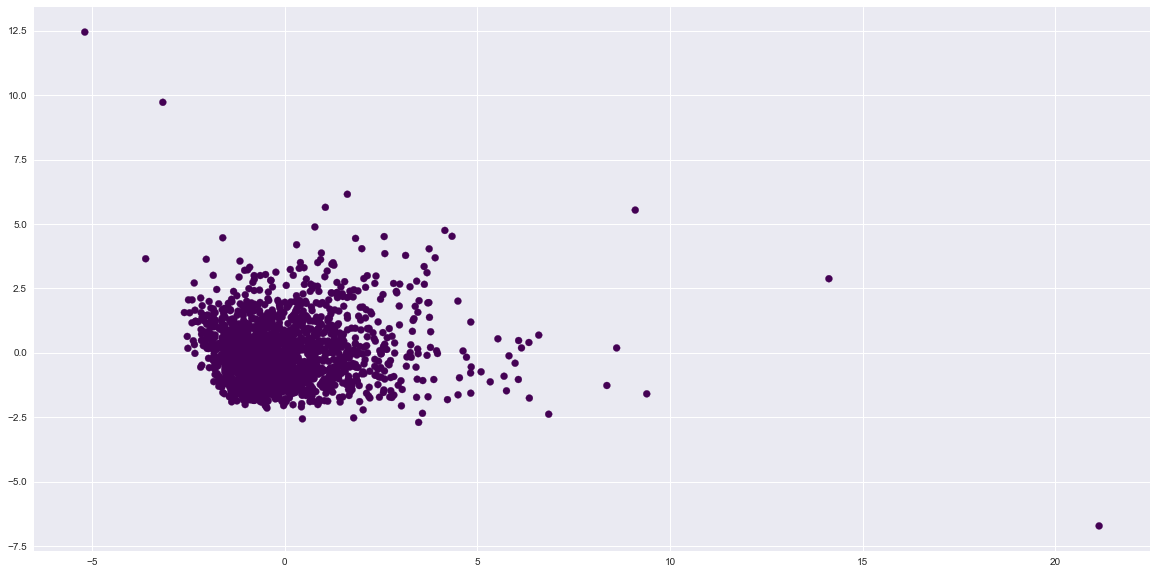

In [409]:
plt.scatter(pca_new[:,0],pca_new[:,1],c=db.labels_,cmap='viridis')

In [79]:
def plot_confusion_matrix(y_true, y_pred, title = 'Confusion matrix', cmap=plt.cm.Blues):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print ('Classification Report:\n')
    print (classification_report(y_test, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    def plot_confusion_matrix_plot(cm, title = 'Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(y_test.unique()))
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    print ('\n Confusion matrix, without normalization: \n')
    print (cm)
    plot_confusion_matrix_plot(cm=cm)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('\n Normalized confusion matrix \n')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix_plot(cm_normalized, title='Normalized confusion matrix')

def makePredThresh (fittedCls, X_test,thr = 0.5 ):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

# RF AND LOGIT FEATURE IMPORTANCE

In [588]:
df.columns

Index(['Месяц выдачи кредита', 'Сумма кредита', 'Срок кредита',
       'Возраст клиента', 'Пол клиента', 'Образование клиента', 'Тип товара',
       'Наличие детей у клиента', 'Регион выдачи кредита', 'Доход клиента',
       'Семейное положение', 'Оператор связи', 'Является ли клиентом банка',
       'Флаг дефолта по кредиту', 'Сбережения после отданной месячной нормы',
       'Сбережения/Зарплата', 'Месяц отдачи кредита',
       'Возраст клиента по категории'],
      dtype='object')

In [589]:
features_to_ohe=['Месяц выдачи кредита',
       'Пол клиента', 'Образование клиента', 'Тип товара',
       'Наличие детей у клиента', 'Регион выдачи кредита',
       'Семейное положение', 'Оператор связи', 'Является ли клиентом банка', 'Месяц отдачи кредита',
       'Возраст клиента по категории']

df_with_dummies=pd.get_dummies(df,columns=features_to_ohe,drop_first=True)

In [590]:
features_to_scale=['Сумма кредита', 'Срок кредита','Возраст клиента',
                   'Доход клиента','Сбережения после отданной месячной нормы',
                   'Сбережения/Зарплата']
mm_scaler=MinMaxScaler()
df_with_dummies[features_to_scale]=mm_scaler.fit_transform(df_with_dummies[features_to_scale])

In [592]:
lr=LogisticRegression(class_weight='balanced',random_state=123)
lr.fit(df_with_dummies.drop(['Флаг дефолта по кредиту'],axis=1),df_with_dummies['Флаг дефолта по кредиту'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [119]:
lr_cv=LogisticRegressionCV(cv=5,class_weight='balanced',scoring='roc_auc',Cs=[0.01,0.5,1,3],n_jobs=-1,random_state=123)
lr_cv.fit(df_with_dummies.drop(['Флаг дефолта по кредиту'],axis=1),df_with_dummies['Флаг дефолта по кредиту'])

LogisticRegressionCV(Cs=[0.01, 0.5, 1, 3], class_weight='balanced', cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

In [135]:
test_scores_mean

array([0.71990562, 0.71980627, 0.71793075, 0.71682458, 0.67823072,
       0.66522207, 0.64333713])

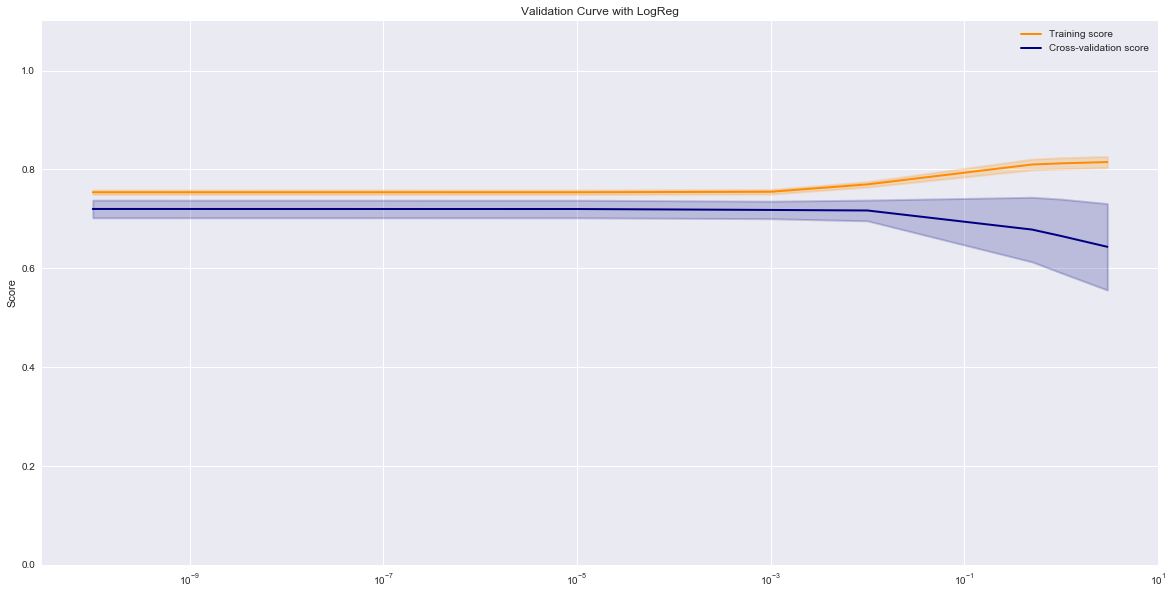

In [593]:
param_range=[0.0000000001,0.00001,0.001,0.01,0.5,1,3]
train_scores, valid_scores = validation_curve(LogisticRegression(class_weight='balanced',random_state=123), df_with_dummies.drop(['Флаг дефолта по кредиту'],axis=1),df_with_dummies['Флаг дефолта по кредиту'], "C",
                                              param_range,scoring="roc_auc",cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with LogReg")
# plt.xlabel("$\$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [603]:
lr=LogisticRegression(C=0.001,class_weight='balanced',random_state=123)
lr.fit(df_with_dummies.drop(['Флаг дефолта по кредиту'],axis=1),df_with_dummies['Флаг дефолта по кредиту'])

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
roc_auc_score(df_with_dummies['Флаг дефолта по кредиту'],lr.predict_proba(df_with_dummies.drop(['Флаг дефолта по кредиту'],axis=1))[:,1])

In [604]:
sorted(list(zip(lr.coef_.reshape(71,1),df_with_dummies.drop(['Флаг дефолта по кредиту'],axis=1).columns.values)))

[(array([-0.06832236]), 'Образование клиента_4'),
 (array([-0.05754535]), 'Пол клиента_1'),
 (array([-0.03944446]), 'Наличие детей у клиента_1'),
 (array([-0.03901923]), 'Тип товара_2'),
 (array([-0.02988215]), 'Возраст клиента по категории_5'),
 (array([-0.02910447]), 'Тип товара_4'),
 (array([-0.0246904]), 'Возраст клиента'),
 (array([-0.02423337]), 'Тип товара_6'),
 (array([-0.01796158]), 'Месяц выдачи кредита_7'),
 (array([-0.01527682]), 'Регион выдачи кредита_1'),
 (array([-0.01459042]), 'Месяц выдачи кредита_2'),
 (array([-0.01456017]), 'Возраст клиента по категории_4'),
 (array([-0.01351042]), 'Тип товара_12'),
 (array([-0.01190255]), 'Образование клиента_3'),
 (array([-0.00935776]), 'Регион выдачи кредита_2'),
 (array([-0.0091154]), 'Сбережения/Зарплата'),
 (array([-0.00833997]), 'Месяц отдачи кредита_9'),
 (array([-0.00789984]), 'Тип товара_13'),
 (array([-0.00774171]), 'Месяц отдачи кредита_11'),
 (array([-0.00674262]), 'Тип товара_20'),
 (array([-0.00614423]), 'Месяц выдачи 

Важность признаков согласно логрегу

In [609]:
rf_clf=RandomForestClassifier(max_depth=3,n_estimators=500)
rf_clf.fit(df.drop(['Флаг дефолта по кредиту'],axis=1),df['Флаг дефолта по кредиту'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

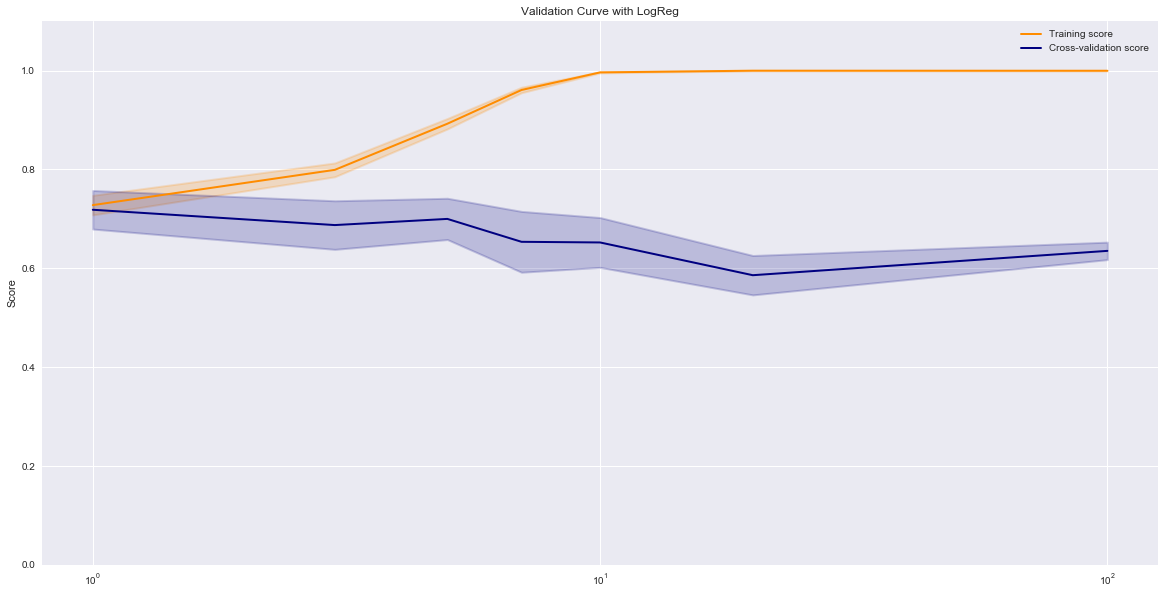

In [177]:
param_range=[100,20,10,7,5,3,1]
train_scores, valid_scores = validation_curve(RandomForestClassifier(), df.drop(['Флаг дефолта по кредиту'],axis=1),df['Флаг дефолта по кредиту'], "max_depth",
                                              param_range,scoring="roc_auc",cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with LogReg")
# plt.xlabel("$\$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

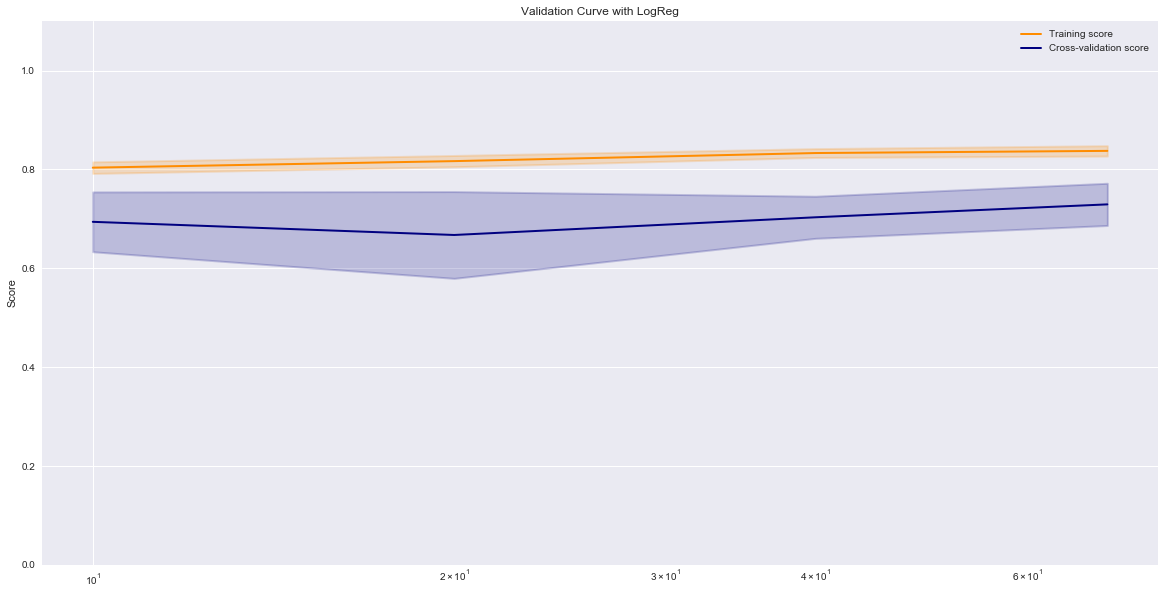

In [187]:
param_range=[10,20,40,70]
train_scores, valid_scores = validation_curve(RandomForestClassifier(max_depth=3), df.drop(['Флаг дефолта по кредиту'],axis=1),df['Флаг дефолта по кредиту'], "n_estimators",
                                              param_range,scoring="roc_auc",cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with LogReg")
# plt.xlabel("$\$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [189]:
roc_auc_score(df['Флаг дефолта по кредиту'],rf_clf.predict_proba(df.drop(['Флаг дефолта по кредиту'],axis=1))[:,1])

0.8235134918407443

In [610]:
sorted(list(zip(rf_clf.feature_importances_,df.drop(['Флаг дефолта по кредиту'],axis=1).columns)))

[(0.005061022769030304, 'Регион выдачи кредита'),
 (0.006577376480567229, 'Наличие детей у клиента'),
 (0.00863887996771653, 'Оператор связи'),
 (0.009125678906722818, 'Семейное положение'),
 (0.01786361252263824, 'Месяц отдачи кредита'),
 (0.024039899820099204, 'Месяц выдачи кредита'),
 (0.036078047084903093, 'Возраст клиента по категории'),
 (0.041290556551739, 'Является ли клиентом банка'),
 (0.04327518319110755, 'Пол клиента'),
 (0.04715402936799481, 'Доход клиента'),
 (0.05555649982802749, 'Сумма кредита'),
 (0.056799802474246784, 'Сбережения после отданной месячной нормы'),
 (0.06635397938216654, 'Сбережения/Зарплата'),
 (0.09698827242426444, 'Возраст клиента'),
 (0.11263703863775187, 'Образование клиента'),
 (0.13126767021527314, 'Срок кредита'),
 (0.2412924503757509, 'Тип товара')]

In [611]:
dt_clf=DecisionTreeClassifier(max_depth=None,criterion='gini',min_samples_leaf=10)
dt_clf.fit(df.drop(['Флаг дефолта по кредиту'],axis=1),df['Флаг дефолта по кредиту'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Draw decision tree

In [612]:
export_graphviz(dt_clf, feature_names=df.drop(['Флаг дефолта по кредиту'],axis=1).columns, 
out_file='small_tree_max_depth.dot', filled=True)
!dot -Tpng small_tree_max_depth.dot -o small_tree_max_depth.png

Confusion Matrix

Classification Report:

             precision    recall  f1-score   support

          0       0.95      0.62      0.75      1527
          1       0.20      0.73      0.31       196

avg / total       0.86      0.64      0.70      1723


 Confusion matrix, without normalization: 

[[952 575]
 [ 52 144]]

 Normalized confusion matrix 

[[0.62344466 0.37655534]
 [0.26530612 0.73469388]]


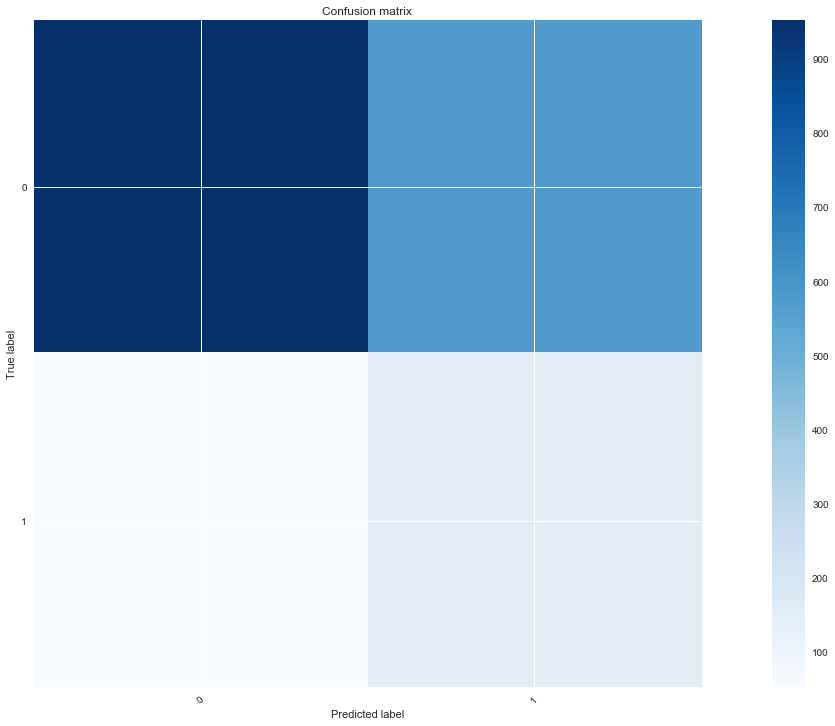

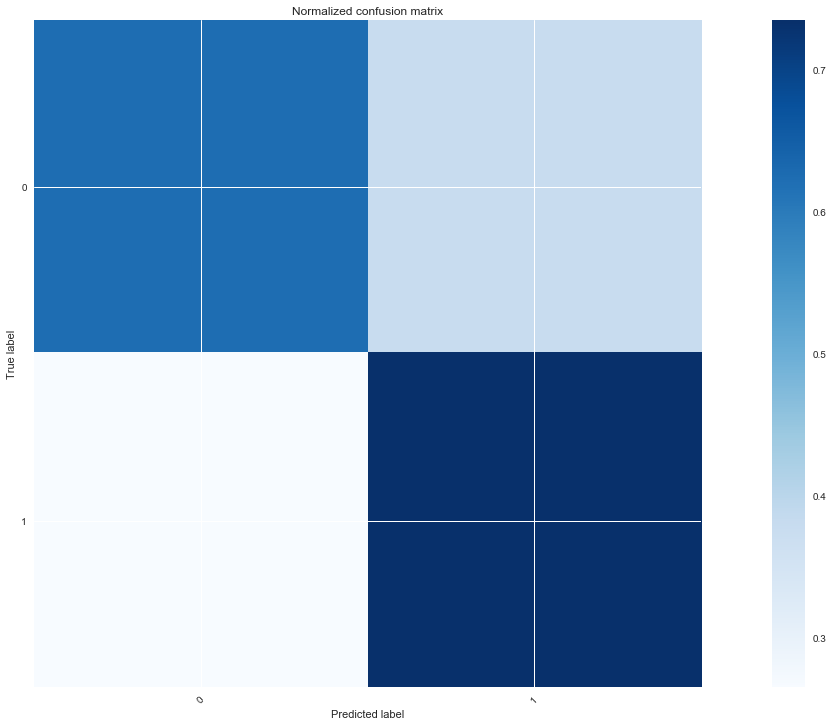

In [154]:
pred = makePredThresh(lr,df_with_dummies.drop(['Флаг дефолта по кредиту'],axis=1), thr=0.5)

y_test=df_with_dummies['Флаг дефолта по кредиту']

plot_confusion_matrix(df['Флаг дефолта по кредиту'], pred)